## 1. IMPORT ALL LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

## 2. LOAD THE DATASET

In [2]:
data = pd.read_excel('./Surface_Water_Data_for_Gilgel_Gibe_Gauging_Station_1995_2021.xlsx')
data.head()

Year      Station  Day  Jan    Feb    Mar    Apr     May     Jun     Jul    \
0  1995  Gilgel Gibe  1.0  3.712  2.456  2.456  2.456  14.302   14.73  35.643   
1  1995  Gilgel Gibe  2.0  4.548  2.456  2.937  2.004  12.632  18.309  33.339   
2  1995  Gilgel Gibe  3.0  4.548  2.456  2.937  1.791  12.226  14.302  31.089   
3  1995  Gilgel Gibe  4.0  4.263  2.456  3.447  1.586  16.041  16.487  29.983   
4  1995  Gilgel Gibe  5.0  4.263  2.456  2.693  1.586  11.427  19.245  32.207   

    Aug      Sep     Oct     Nov    Dec    
0  49.872   95.614  31.646  10.647  5.439  
1  56.552   95.614  29.436   9.886  5.136  
2  66.374  100.556  27.281  10.264  5.136  
3  93.175  111.551  26.225  11.427  4.839  
4  99.726   122.93  25.183  11.035  4.548

In [3]:
data.Station.value_counts()

Station
Gilgel Gibe                        806
Gilgel Gibe                         31
Mean                                27
Flow million cubic meters (MCM)     27
Maximum                             27
Minimum                             27
Runoff (mm)                         27
Flow (cumecs)                        1
Name: count, dtype: int64

In [4]:
# List of stations to keep
stations_to_keep = ["Mean", "Flow million cubic meters (MCM)", "Maximum", "Minimum", "Runoff (mm)"]

# Filter the dataframe
filtered_df = data[data["Station"].isin(stations_to_keep)]
filtered_df.tail()

Year                          Station  Day   Jan    Feb    Mar     Apr    \
968  2021                             Mean  NaN  11.428  3.615  2.879   7.517   
969  2021  Flow million cubic meters (MCM)  NaN   5.260  8.746  7.710  19.483   
970  2021                          Maximum  NaN   3.106  8.051  6.054  21.527   
971  2021                          Minimum  NaN   3.853  2.363  1.952   2.169   
972  2021                      Runoff (mm)  NaN   3.479  2.949  2.599   6.569   

       May     Jun      Jul      Aug      Sep      Oct     Nov     Dec    
968   47.851  33.342  100.918  162.894  102.853   80.198  11.949   5.373  
969  128.163  86.422  270.298  161.426  103.858  214.803  30.973  14.392  
970   65.531  71.922  158.868   162.16  103.355  167.661  17.875   7.063  
971   21.630  15.402   67.653  161.793  103.606   18.925   7.301   4.240  
972   43.211  29.138   91.132  161.976  103.229   72.422  10.443   4.852

In [5]:
filtered_df.rename(columns={'Station':'Parameter'}, inplace=True)
filtered_df.drop(columns={'Day'}, inplace=True)
filtered_df.head()

Year                        Parameter  Jan    Feb    Mar     Apr    \
31  1995                             Mean  3.261  3.074  2.937   8.122   
32  1995  Flow million cubic meters (MCM)  8.735  7.436  2.539  21.051   
33  1995                          Maximum  4.548  4.548  6.800  22.146   
34  1995                          Minimum  2.226  2.456  4.548   1.586   
35  1995                      Runoff (mm)  2.945  2.507  1.389   7.098   

     May     Jun      Jul      Aug      Sep     Oct     Nov     Dec    
31  12.226  15.264   51.185   93.986    79.09  10.647   8.008  13.043  
32  11.863  39.564   45.452   65.424      205  18.852  20.758   6.241  
33  31.774  35.062  121.738  175.231  144.908  50.494  11.427  16.716  
34  16.041    8.07   75.965   99.726    33.91  31.646   5.749  13.878  
35   6.384  13.339   29.983   49.872   69.117  10.647   6.999   4.548

## 3. TRANSFORM THE DATASET

In [6]:
# Remove extra spaces
filtered_df.columns = filtered_df.columns.str.strip()
filtered_df.head()

Year                        Parameter    Jan    Feb    Mar     Apr  \
31  1995                             Mean  3.261  3.074  2.937   8.122   
32  1995  Flow million cubic meters (MCM)  8.735  7.436  2.539  21.051   
33  1995                          Maximum  4.548  4.548  6.800  22.146   
34  1995                          Minimum  2.226  2.456  4.548   1.586   
35  1995                      Runoff (mm)  2.945  2.507  1.389   7.098   

       May     Jun      Jul      Aug      Sep     Oct     Nov     Dec  
31  12.226  15.264   51.185   93.986    79.09  10.647   8.008  13.043  
32  11.863  39.564   45.452   65.424      205  18.852  20.758   6.241  
33  31.774  35.062  121.738  175.231  144.908  50.494  11.427  16.716  
34  16.041    8.07   75.965   99.726    33.91  31.646   5.749  13.878  
35   6.384  13.339   29.983   49.872   69.117  10.647   6.999   4.548

In [7]:
filtered_df.columns

Index(['Year', 'Parameter', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul',
       'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
      dtype='object')

In [8]:
def transform_data(df):
    # Melt the dataframe
    melted_df = df.melt(id_vars=["Parameter", "Year"],
                        value_vars=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"],
                        var_name="Month", value_name="Value")

    # Map month names to numbers
    month_mapping = {
        "Jan": "01", "Feb": "02", "Mar": "03", "Apr": "04", "May": "05", "Jun": "06",
        "Jul": "07", "Aug": "08", "Sep": "09", "Oct": "10", "Nov": "11", "Dec": "12"
    }
    melted_df["Month"] = melted_df["Month"].map(month_mapping)

    # Combine Year and Month into a Date column
    melted_df["Date"] = pd.to_datetime(melted_df["Year"].astype(str) + "-" + melted_df["Month"] + "-01")

    # Select and reorder the final columns
    transformed_df = melted_df[["Parameter", "Date", "Value"]]

    return transformed_df



In [9]:
# Transform the data
transformed_data = transform_data(filtered_df)

In [10]:
transformed_data.head()

Parameter       Date  Value
0                             Mean 1995-01-01  3.261
1  Flow million cubic meters (MCM) 1995-01-01  8.735
2                          Maximum 1995-01-01  4.548
3                          Minimum 1995-01-01  2.226
4                      Runoff (mm) 1995-01-01  2.945

In [11]:
# UNIQUE VALUES ONLY
unique_parameters = transformed_data['Parameter'].unique()

In [12]:
for value in transformed_data['Value']:
    if isinstance(value, (int, float)):
        continue
    else:
        print(value)

In [13]:
transformed_data.Value.isnull().sum()

0

In [14]:
# Convert 'Value' column to float
transformed_data['Value'] = transformed_data['Value'].astype(float)

In [15]:
# RENAMA THE PARAMETERS
rename_dict = {
    unique_parameters[0]: 'Mean Flow',
    unique_parameters[1]: 'FLow',
    unique_parameters[2]: 'Max FLow',
    unique_parameters[3]: 'Min Flow',
    unique_parameters[4]: 'Runoff'
}

# Renaming the parameters
transformed_data['Parameter'] = transformed_data['Parameter'].replace(rename_dict)
transformed_data.head()

Parameter       Date  Value
0  Mean Flow 1995-01-01  3.261
1       FLow 1995-01-01  8.735
2   Max FLow 1995-01-01  4.548
3   Min Flow 1995-01-01  2.226
4     Runoff 1995-01-01  2.945

In [16]:
# Parameter counts
transformed_data.Parameter.value_counts()

Parameter
Mean Flow    324
FLow         324
Max FLow     324
Min Flow     324
Runoff       324
Name: count, dtype: int64

## 4. PLOT VALUES OF EACH PARAMETERS

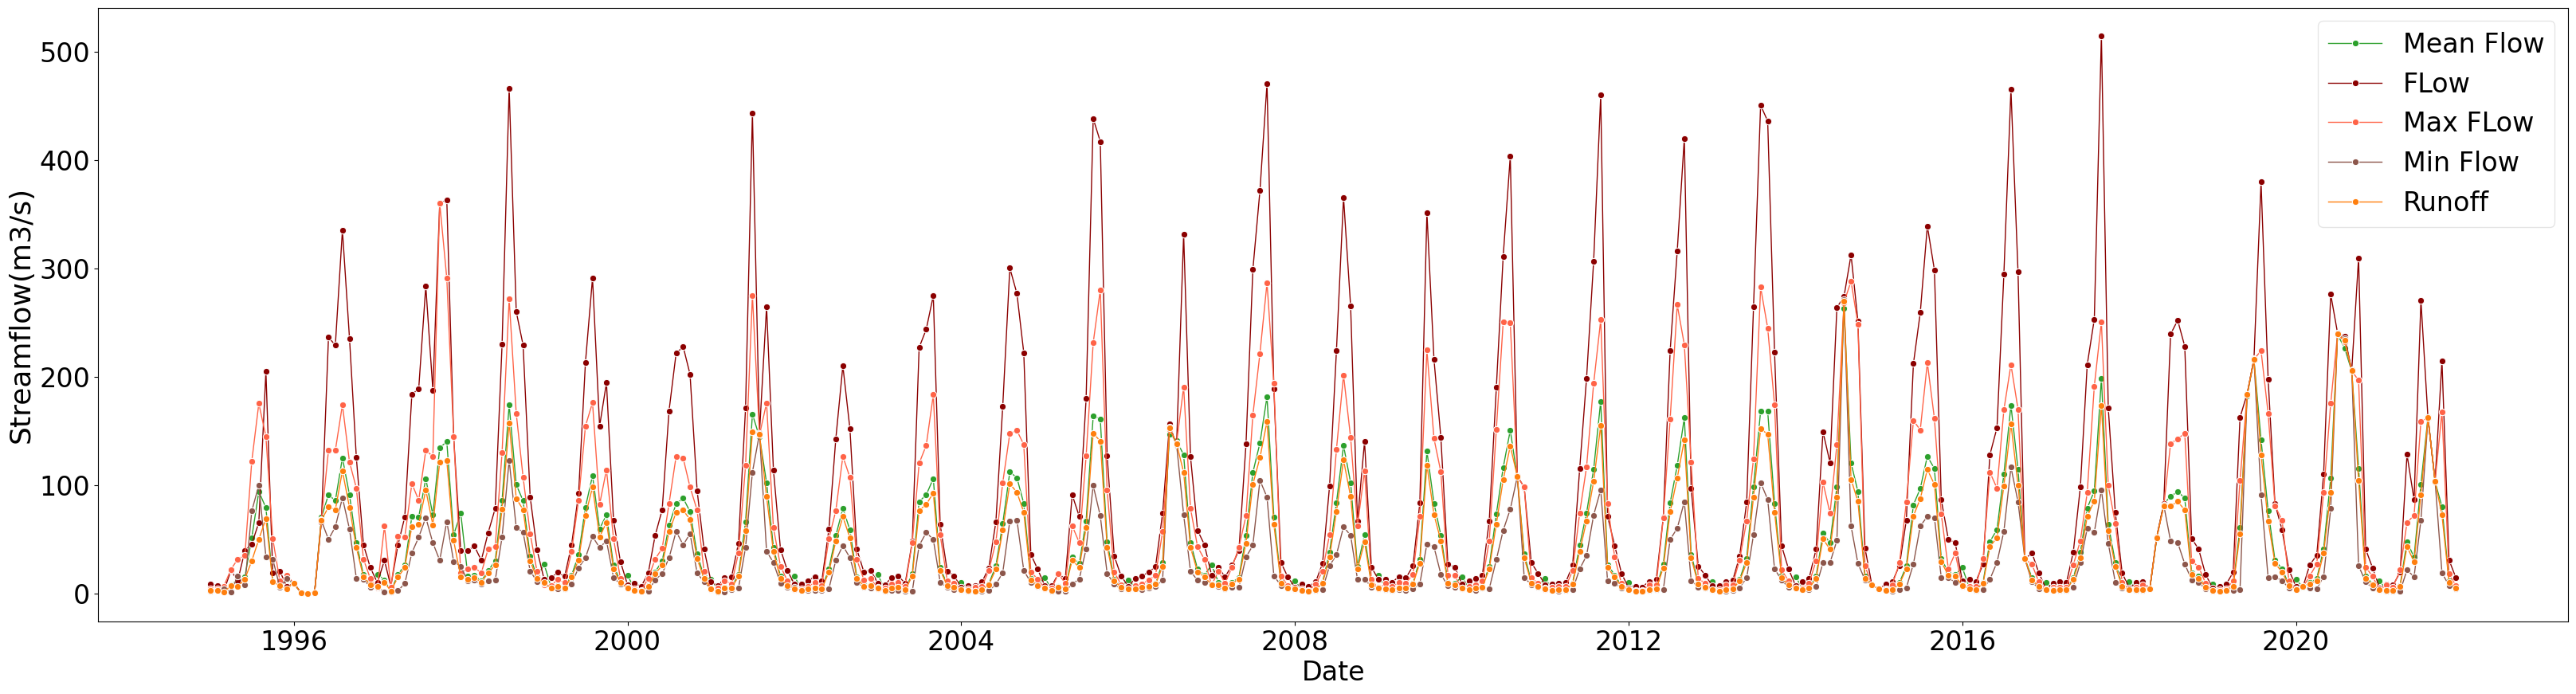

In [17]:
parameters = transformed_data['Parameter'].unique()

custom_colors = {
    parameters[0]: '#2ca02c',
    parameters[1]: '#8b0000',
    parameters[2]: '#ff6347',
    parameters[3]: '#8c564b',
    parameters[4]: '#ff7f0e',
}

plt.figure(figsize=(40, 10))

for parameter in parameters:
    parameter_data = transformed_data[transformed_data['Parameter'] == parameter]
    parameter_data.set_index('Date', inplace=True)
    sns.lineplot(data=parameter_data,
                 x=parameter_data.index,
                 y='Value',
                 marker='o',
                 label=parameter,
                 linewidth=1,
                 color=custom_colors[parameter])

# plt.title('Monthly Analysis', fontsize=24)
plt.xlabel('Date', fontsize=24)
plt.ylabel('Streamflow(m3/s)', fontsize=26)
plt.legend(loc='best', fontsize=24, framealpha=0.5)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.show()

In [18]:
parameters = transformed_data['Parameter'].unique()
parameters

array(['Mean Flow', 'FLow', 'Max FLow', 'Min Flow', 'Runoff'],
      dtype=object)

## 5. FIND THE CORRELATIONS BETWEEN EACH PARAMETERS

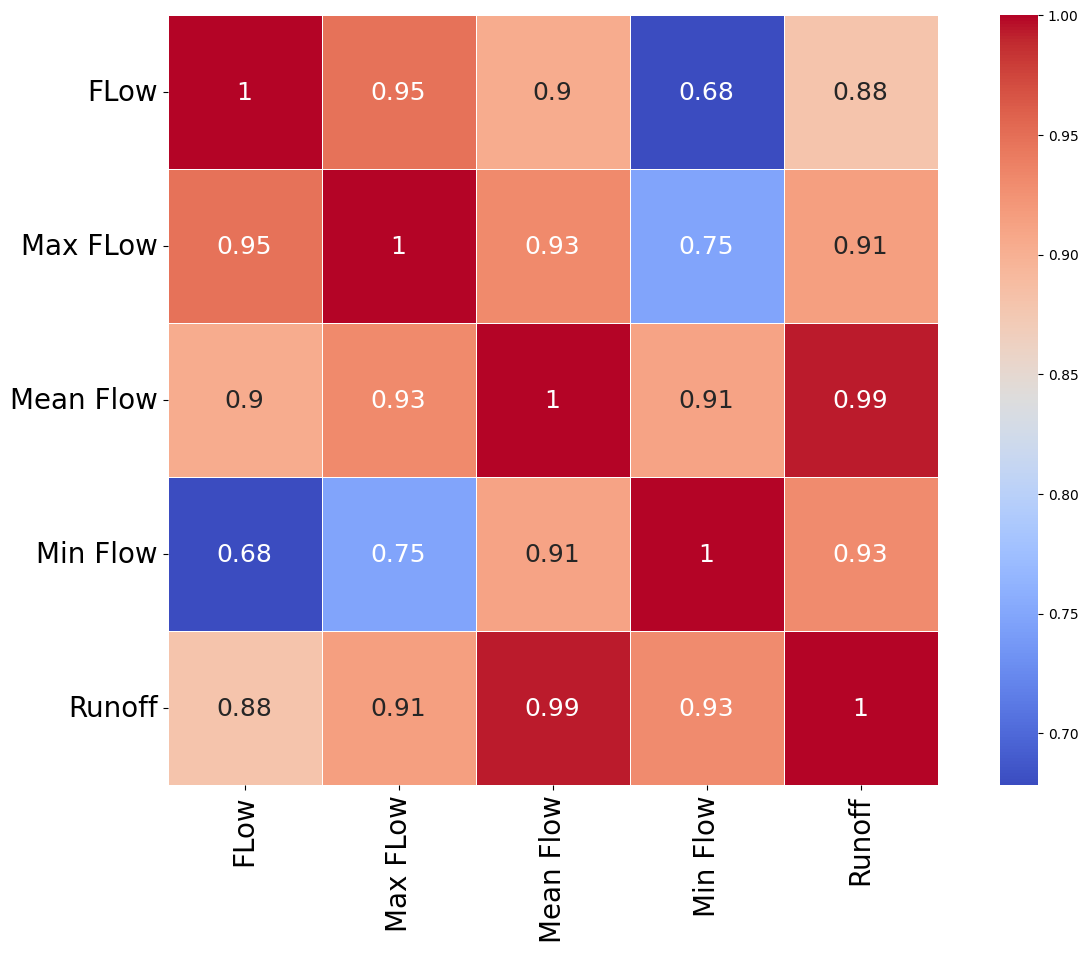

In [19]:
# Assuming transformed_data is already defined
pivot_data = transformed_data.pivot(index='Date', columns='Parameter', values='Value')
correlation_matrix = pivot_data.corr()

plt.figure(figsize=(16, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True, linewidths=0.5, annot_kws={"size": 18})

# Adjust x-tick and y-tick labels rotation
plt.xticks(rotation=90, fontsize=20)
plt.yticks(rotation=0, fontsize=20)

plt.xlabel('')
plt.ylabel('')
plt.show()

## 6. COMMON FUNCTION

### TIME SERIES TO SUPERVISED

In [20]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols = []
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    agg = pd.concat(cols, axis=1)
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values

### ADD ROLLING FEATURES

In [21]:
def add_rolling_features(data, window=3):
    df = pd.DataFrame(data)
    df['rolling_mean'] = df.iloc[:, 0].rolling(window=window).mean()
    df['rolling_std'] = df.iloc[:, 0].rolling(window=window).std()
    df.dropna(inplace=True)
    return df

### TRAIN TEST SPLITT

In [22]:
def train_test_split(data, train_size=0.9):
    n_train = int(len(data) * train_size)
    return data[:n_train], data[n_train:]

### MEASURING METRICS

In [23]:
def nash_sutcliffe_efficiency(y_true, y_pred):
    return 1 - (np.sum((y_true - y_pred)**2) / np.sum((y_true - np.mean(y_true))**2))
def willmotts_index(y_true, y_pred):
    return 1 - (np.sum((y_pred - y_true)**2) / np.sum((np.abs(y_pred - np.mean(y_true)) + np.abs(y_true - np.mean(y_true)))**2))


### CROSS VALIDATION AND MODEL EVALUATIONS

In [24]:
def walk_forward_validation(data, model):
    predictions = []
    train, test = train_test_split(data)
    history = [x for x in train.values]
    for i in range(len(test)):
        testX, testy = test.iloc[i, :-1].values, test.iloc[i, -1]
        yhat = model(history, testX)
        predictions.append(yhat)
        history.append(test.iloc[i].values)
        print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
    mae = mean_absolute_error(test.iloc[:, -1], predictions)
    rmse = np.sqrt(np.mean((test.iloc[:, -1] - np.asarray(predictions))**2))
    r2 = r2_score(test.iloc[:, -1], predictions)
    nse = nash_sutcliffe_efficiency(test.iloc[:, -1], predictions)
    willmott = willmotts_index(test.iloc[:, -1], predictions)
    return mae, rmse, r2, nse, willmott, test.index, test.iloc[:, -1], predictions

## 7. MODELS


### 1. RANDOM FOREST

In [25]:
def random_forest_forecast(train, testX):
    train = np.asarray(train)
    trainX, trainy = train[:, :-1], train[:, -1]
    model = RandomForestRegressor(n_estimators=50)
    model.fit(trainX, trainy)
    yhat = model.predict([testX])
    return yhat[0]

### 2. SVM

In [26]:
from sklearn.svm import SVR
def svm_forecast(train, testX):
    train = np.asarray(train)
    trainX, trainy = train[:, :-1], train[:, -1]
    model = SVR(kernel='rbf')
    model.fit(trainX, trainy)
    yhat = model.predict([testX])
    return yhat[0]


### 3. XGBRegressor

In [27]:
from xgboost import XGBRegressor
def xgboost_forecast(train, testX):
    train = np.asarray(train)
    trainX, trainy = train[:, :-1], train[:, -1]
    model = XGBRegressor(n_estimators=50)
    model.fit(trainX, trainy)
    yhat = model.predict([testX])
    return yhat[0]


### 4. LGBMRegressor


In [28]:
from lightgbm import LGBMRegressor
def lightgbm_forecast(train, testX):
    train = np.asarray(train)
    trainX, trainy = train[:, :-1], train[:, -1]
    model = LGBMRegressor(n_estimators=50, verbose=-1)
    model.fit(trainX, trainy)
    yhat = model.predict([testX])
    return yhat[0]


In [29]:
# Color dictionary for different models
colors_dict = {
    'LightGBM': '#27ad81',
    'XGBoost': '#5dc863',
    'SVM': '#aadc32',
    'Random Forest': '#fde725'
}

## 6. MEAN FLOW ANALYSIS

In [30]:
# Get the mean values
mean_flow = transformed_data[transformed_data['Parameter'] == parameters[0]]
mean_flow.head()

Parameter       Date   Value
0   Mean Flow 1995-01-01   3.261
5   Mean Flow 1996-01-01   9.181
10  Mean Flow 1997-01-01  17.626
15  Mean Flow 1998-01-01  74.108
20  Mean Flow 1999-01-01  26.971

In [31]:
# drop the parameter columns
mean_flow = mean_flow.drop(columns=['Parameter'])

In [32]:
mean_flow.head()

Date   Value
0  1995-01-01   3.261
5  1996-01-01   9.181
10 1997-01-01  17.626
15 1998-01-01  74.108
20 1999-01-01  26.971

In [33]:
# sort according to  the date
mean_flow= mean_flow.sort_values(by='Date')
mean_flow.head()

Date   Value
0   1995-01-01   3.261
135 1995-02-01   3.074
270 1995-03-01   2.937
405 1995-04-01   8.122
540 1995-05-01  12.226

In [34]:
mean_flow.head()

Date   Value
0   1995-01-01   3.261
135 1995-02-01   3.074
270 1995-03-01   2.937
405 1995-04-01   8.122
540 1995-05-01  12.226

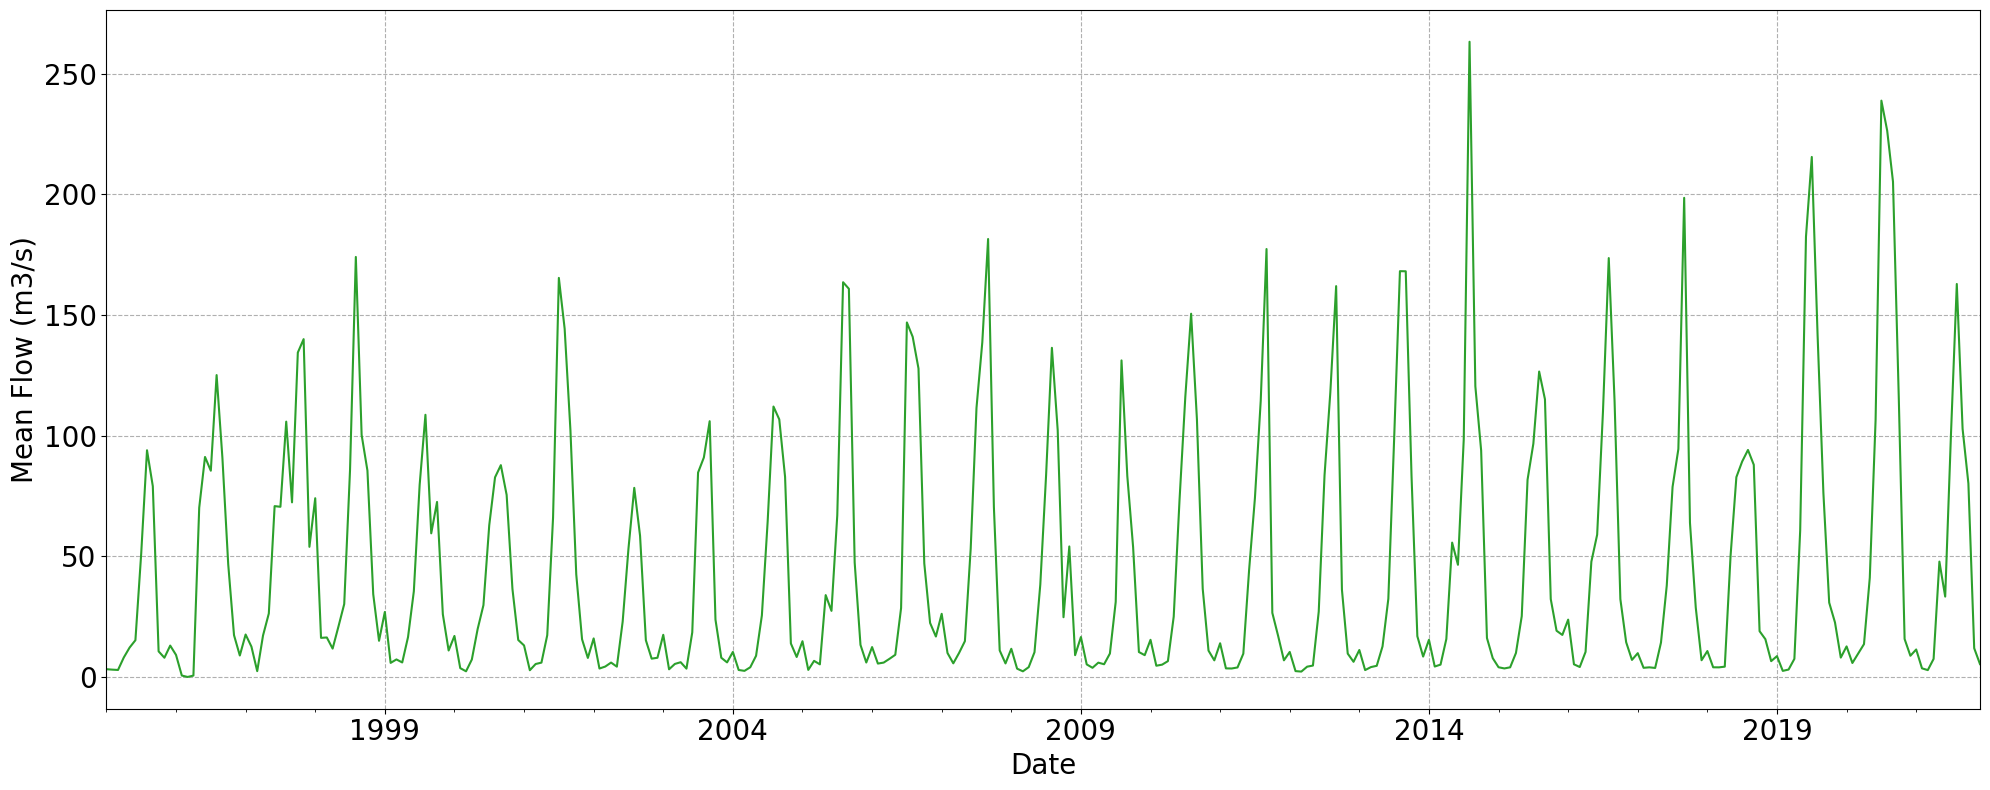

In [35]:
plt.figure(figsize=(20, 8))
mean_flow.plot(x='Date', y='Value', kind='line', ax=plt.gca(), color='#2ca02c', fontsize=12)
plt.xlabel('Date', fontdict={'fontsize':20})
plt.ylabel('Mean Flow (m3/s)', fontdict={'fontsize':20})
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.grid(linestyle='--')
plt.tight_layout()
plt.legend().remove()
plt.show()

In [36]:
# Add fuller test to check the stationarity of the dataset
def adfuller_test(values):
    result = adfuller(values)
    labels = ['ADF Test Statistic','p-value','#Lags Used', 'Number of Observations Used']
    for value, label in zip(result, labels):
        print(label+' : '+str(value))
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis(H0)")
    else:
        print("Weak evidence against the null hypothesis(H0)")

In [37]:
# H0: It is non stationary
# H1: It is stationary

In [38]:
adfuller_test(mean_flow['Value'])

ADF Test Statistic : -3.547283596750242
p-value : 0.006852616092827493
#Lags Used : 13
Number of Observations Used : 310
Strong evidence against the null hypothesis(H0)


In [39]:
mean_flow = mean_flow[['Date', 'Value']]
mean_flow.set_index('Date', inplace=True)
mean_flow.head()

Value
Date              
1995-01-01   3.261
1995-02-01   3.074
1995-03-01   2.937
1995-04-01   8.122
1995-05-01  12.226

In [40]:
model_names = []
mae_values = []
rmse_values = []
r2_values = []
nse_values = []
willmott_values = []

### TRAIN THE MODEL

In [41]:
# Assuming `mean flow` is your time series DataFrame
series = mean_flow
values = series.values
values = add_rolling_features(values, window=3)
values = pd.DataFrame(values).values
scaler = StandardScaler()
values = scaler.fit_transform(values)
data = series_to_supervised(values, n_in=6)
data_df = pd.DataFrame(data, index=series.index[6+2:])

>expected=0.3, predicted=0.1
>expected=2.7, predicted=1.6
>expected=2.4, predicted=1.4
>expected=0.5, predicted=1.7
>expected=1.9, predicted=1.1
>expected=1.3, predicted=2.1
>expected=0.2, predicted=0.7
>expected=-0.6, predicted=-0.6
>expected=-0.8, predicted=-0.8
>expected=-0.9, predicted=-0.8
>expected=-0.9, predicted=-0.8
>expected=-0.9, predicted=-0.8
>expected=-0.3, predicted=-0.4
>expected=0.9, predicted=0.8
>expected=3.2, predicted=1.6
>expected=2.0, predicted=1.6
>expected=-0.4, predicted=1.8
>expected=1.4, predicted=0.9
>expected=2.9, predicted=1.8
>expected=1.5, predicted=1.4
>expected=-0.9, predicted=-0.8
>expected=-0.9, predicted=-0.9
>expected=-0.9, predicted=-0.9
>expected=-1.0, predicted=-1.0
>expected=-0.0, predicted=-0.2
>expected=-0.2, predicted=0.0
>expected=0.4, predicted=0.2
>expected=1.7, predicted=1.6
>expected=0.4, predicted=0.3
>expected=0.7, predicted=1.5
>expected=0.9, predicted=1.0
>expected=0.7, predicted=0.6
>expected=0.3, predicted=0.1
>expected=2.7, pred

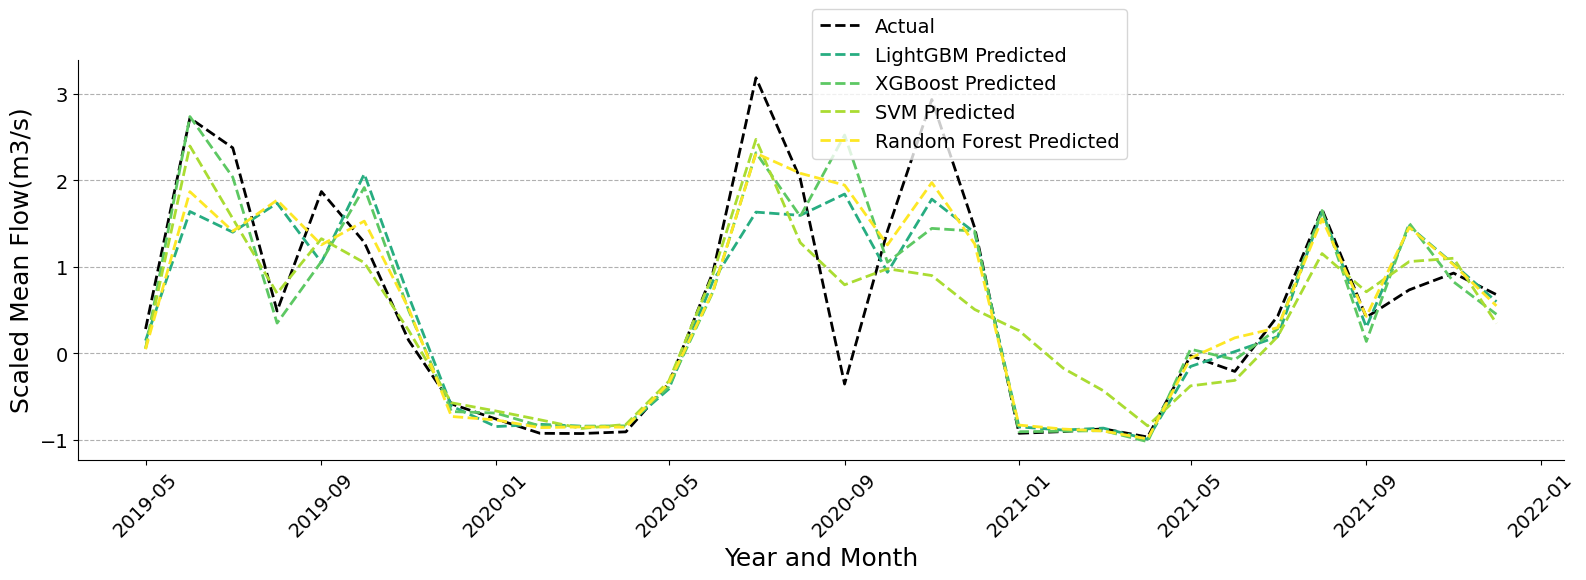

In [42]:

# Model names
models = [
    ('LightGBM', lightgbm_forecast),
    ('XGBoost', xgboost_forecast),
    ('SVM', svm_forecast),
    ('Random Forest', random_forest_forecast)
]

# Clear existing lists in case they contain previous values
model_names.clear()
mae_values.clear()
rmse_values.clear()
r2_values.clear()
nse_values.clear()
willmott_values.clear()

# Iterate over each model, perform walk-forward validation, and append metrics to lists
for model_name, model_func in models:
    mae, rmse, r2, nse, willmott, test_index, y, yhat = walk_forward_validation(data_df, model_func)
    
    model_names.append(model_name)
    mae_values.append(mae)
    rmse_values.append(rmse)
    r2_values.append(r2)
    nse_values.append(nse)
    willmott_values.append(willmott)

# Create a DataFrame
metrics = {
    'Model': model_names,
    'MAE': mae_values,
    'RMSE': rmse_values,
    'R-squared': r2_values,
    'Nash-Sutcliffe Efficiency': nse_values,
    'Willmott\'s Index of Agreement': willmott_values
}

metrics_df = pd.DataFrame(metrics)

# Plot the actual vs predicted values for each model
plt.figure(figsize=(16, 6))
plt.plot(test_index, y, label='Actual', linestyle='--', color='black', linewidth=2)



# Plot predictions for each model
for model_name, model_func in models:
    _, _, _, _, _, test_index, _, yhat = walk_forward_validation(data_df, model_func)
    plt.plot(test_index, yhat, label=f'{model_name} Predicted', linestyle='--', color=colors_dict[model_name], linewidth=2)

plt.xlabel('Year and Month', fontsize=18)
plt.ylabel('Scaled Mean Flow(m3/s)', fontsize=18)
plt.legend(fontsize=14, loc='upper center', bbox_to_anchor=(0.6, 1.15), ncol=1)
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)

plt.grid(axis='y', linestyle='--')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

### EVALUATE THE MODEL

In [43]:
# Create a DataFrame
metrics = {
    'Model': model_names,
    'MAE': mae_values,
    'RMSE': rmse_values,
    'R-squared': r2_values,
    'Nash-Sutcliffe Efficiency': nse_values,
    'Willmott\'s Index of Agreement': willmott_values
}

metrics = pd.DataFrame(metrics)

In [44]:
metrics

Model       MAE      RMSE  R-squared  Nash-Sutcliffe Efficiency  \
0       LightGBM  0.428523  0.683382   0.695610                   0.695610   
1        XGBoost  0.346418  0.656517   0.719072                   0.719072   
2            SVM  0.429519  0.607130   0.759748                   0.759748   
3  Random Forest  0.382435  0.612480   0.755495                   0.755495   

   Willmott's Index of Agreement  
0                       0.904407  
1                       0.920369  
2                       0.915041  
3                       0.927202

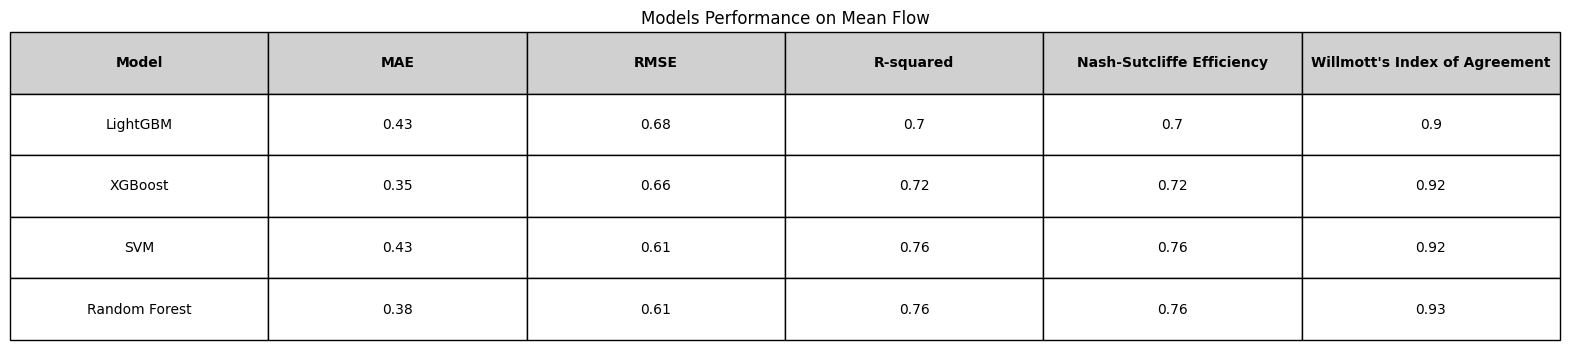

In [45]:
metrics = metrics.round(2)

fig, ax = plt.subplots(figsize=(20, 4))
ax.axis('off')

table = ax.table(cellText=metrics.values,
                 colLabels=metrics.columns,
                 cellLoc='center',
                 loc='center',
                 bbox=[0, 0, 1, 1])

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

header_color = '#D0D0D0'
data_color = '#FFFFFF'

for i, key in enumerate(table._cells):
    cell = table._cells[key]
    cell.set_edgecolor('black')
    if key[0] == 0 or key[1] == -1:
        cell.set_text_props(weight='bold')
        cell.set_facecolor(header_color)
    else:
        cell.set_facecolor(data_color)

plt.title('Models Performance on Mean Flow')
plt.show()


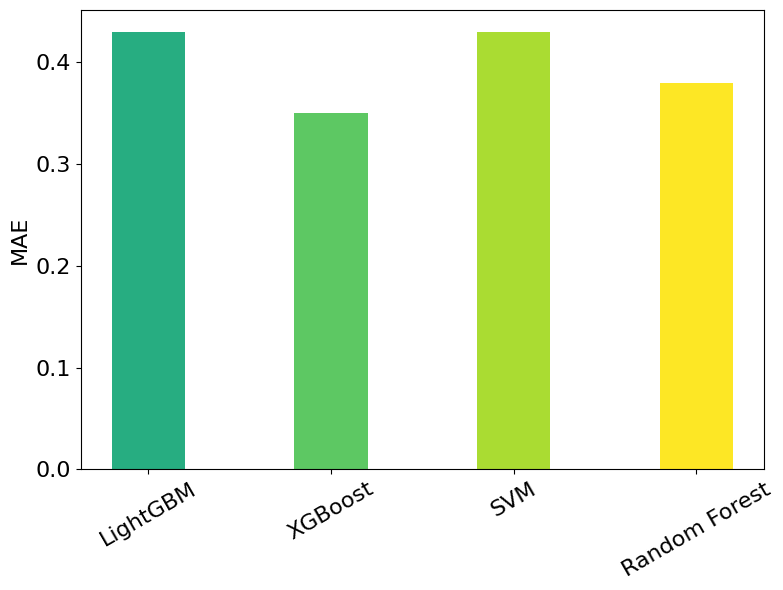

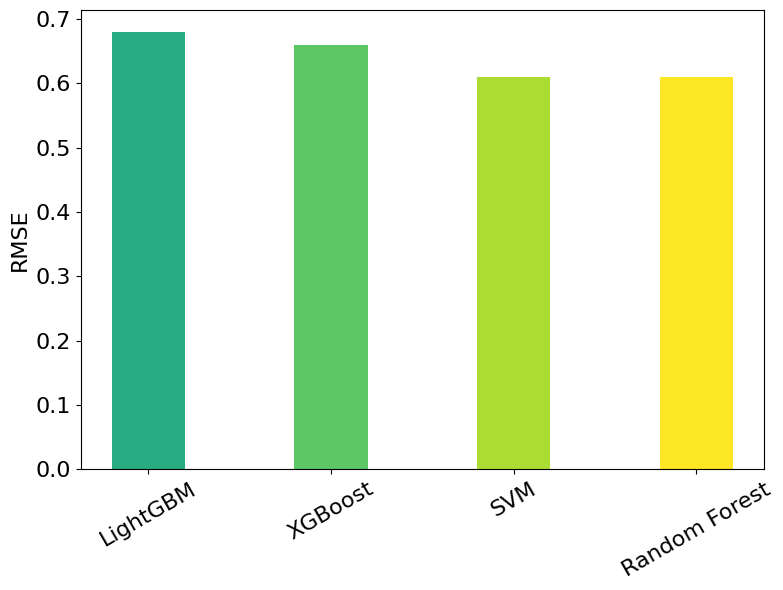

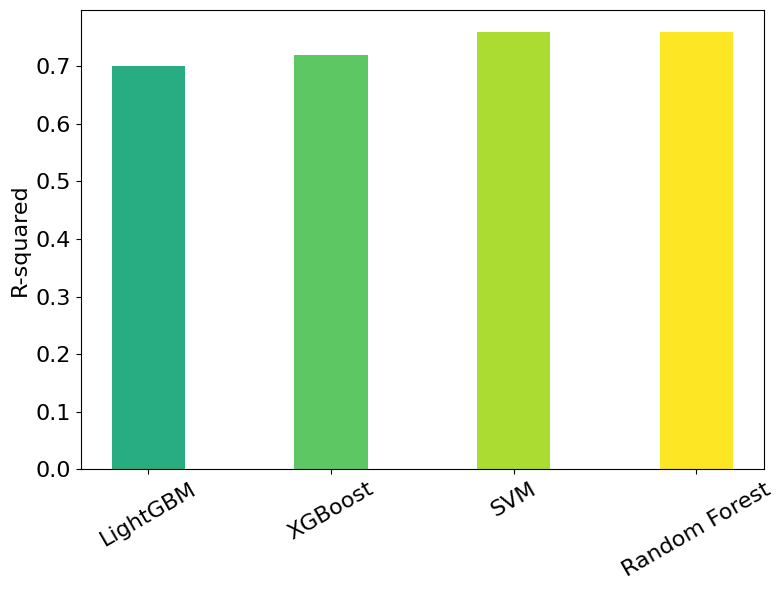

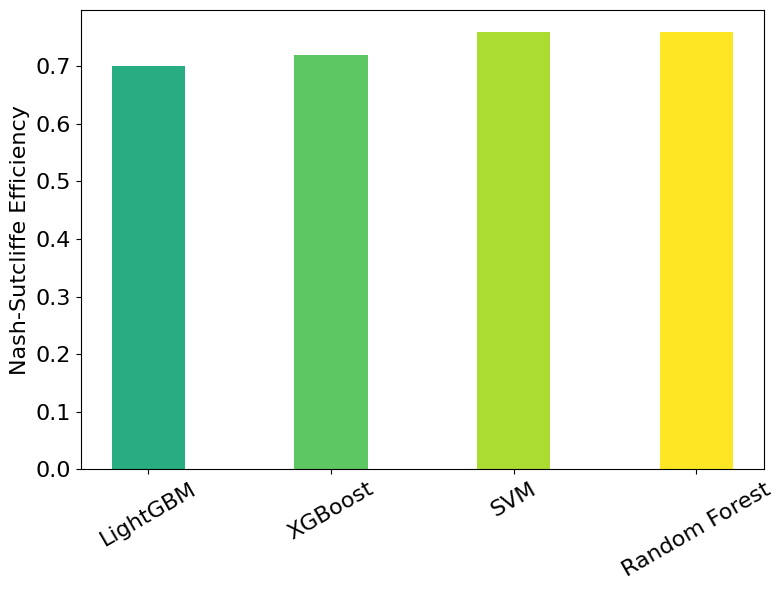

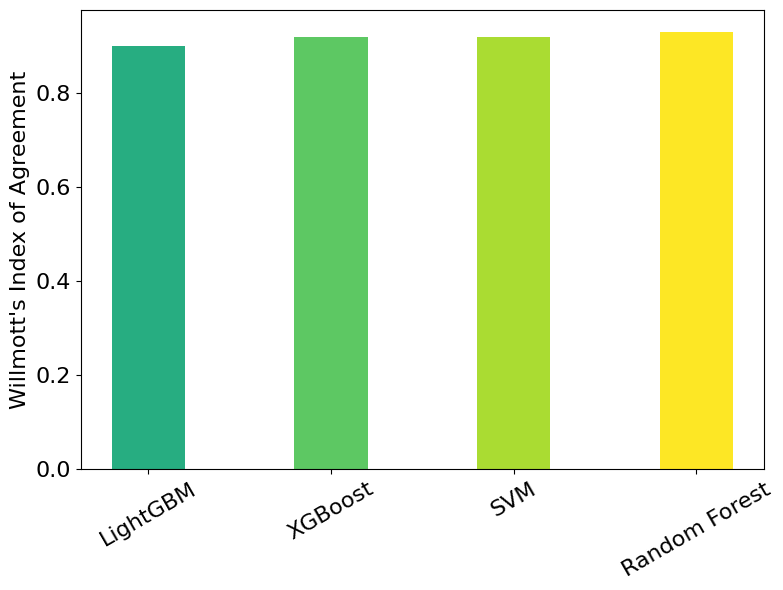

In [46]:

colors = ['#27ad81', '#5dc863', '#aadc32', '#fde725']
bar_width = 0.4

# Metrics and Titles
metrics_title = {
    'MAE': 'Mean Absolute Error (MAE)',
    'RMSE': 'Root Mean Squared Error (RMSE)',
    'R-squared': 'R-squared',
    'Nash-Sutcliffe Efficiency': 'Nash-Sutcliffe Efficiency',
    'Willmott\'s Index of Agreement': 'Willmott\'s Index of Agreement'
}

# Plot each metric separately
for metric, title in metrics_title.items():
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.bar(metrics['Model'], metrics[metric], color=colors, width=bar_width)
    # ax.set_title(title, fontsize=16)
    ax.set_ylabel(metric, fontsize=16)
    ax.tick_params(axis='x', rotation=30, labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    plt.tight_layout()
    plt.show()


## 7. FLOW ANALYSIS

In [47]:
# Get the temp_max values
flow = transformed_data[transformed_data['Parameter'] == parameters[1]]
flow.head()

Parameter       Date   Value
1       FLow 1995-01-01   8.735
6       FLow 1996-01-01   9.706
11      FLow 1997-01-01   9.886
16      FLow 1998-01-01  39.197
21      FLow 1999-01-01  13.043

In [48]:
# drop the parameter columns
flow = flow.drop(columns=['Parameter'])

In [49]:
flow.head()

Date   Value
1  1995-01-01   8.735
6  1996-01-01   9.706
11 1997-01-01   9.886
16 1998-01-01  39.197
21 1999-01-01  13.043

In [50]:
# sort according to  the date
flow= flow.sort_values(by='Date')
flow.head()

Date   Value
1   1995-01-01   8.735
136 1995-02-01   7.436
271 1995-03-01   2.539
406 1995-04-01  21.051
541 1995-05-01  11.863

In [51]:
flow.head()

Date   Value
1   1995-01-01   8.735
136 1995-02-01   7.436
271 1995-03-01   2.539
406 1995-04-01  21.051
541 1995-05-01  11.863

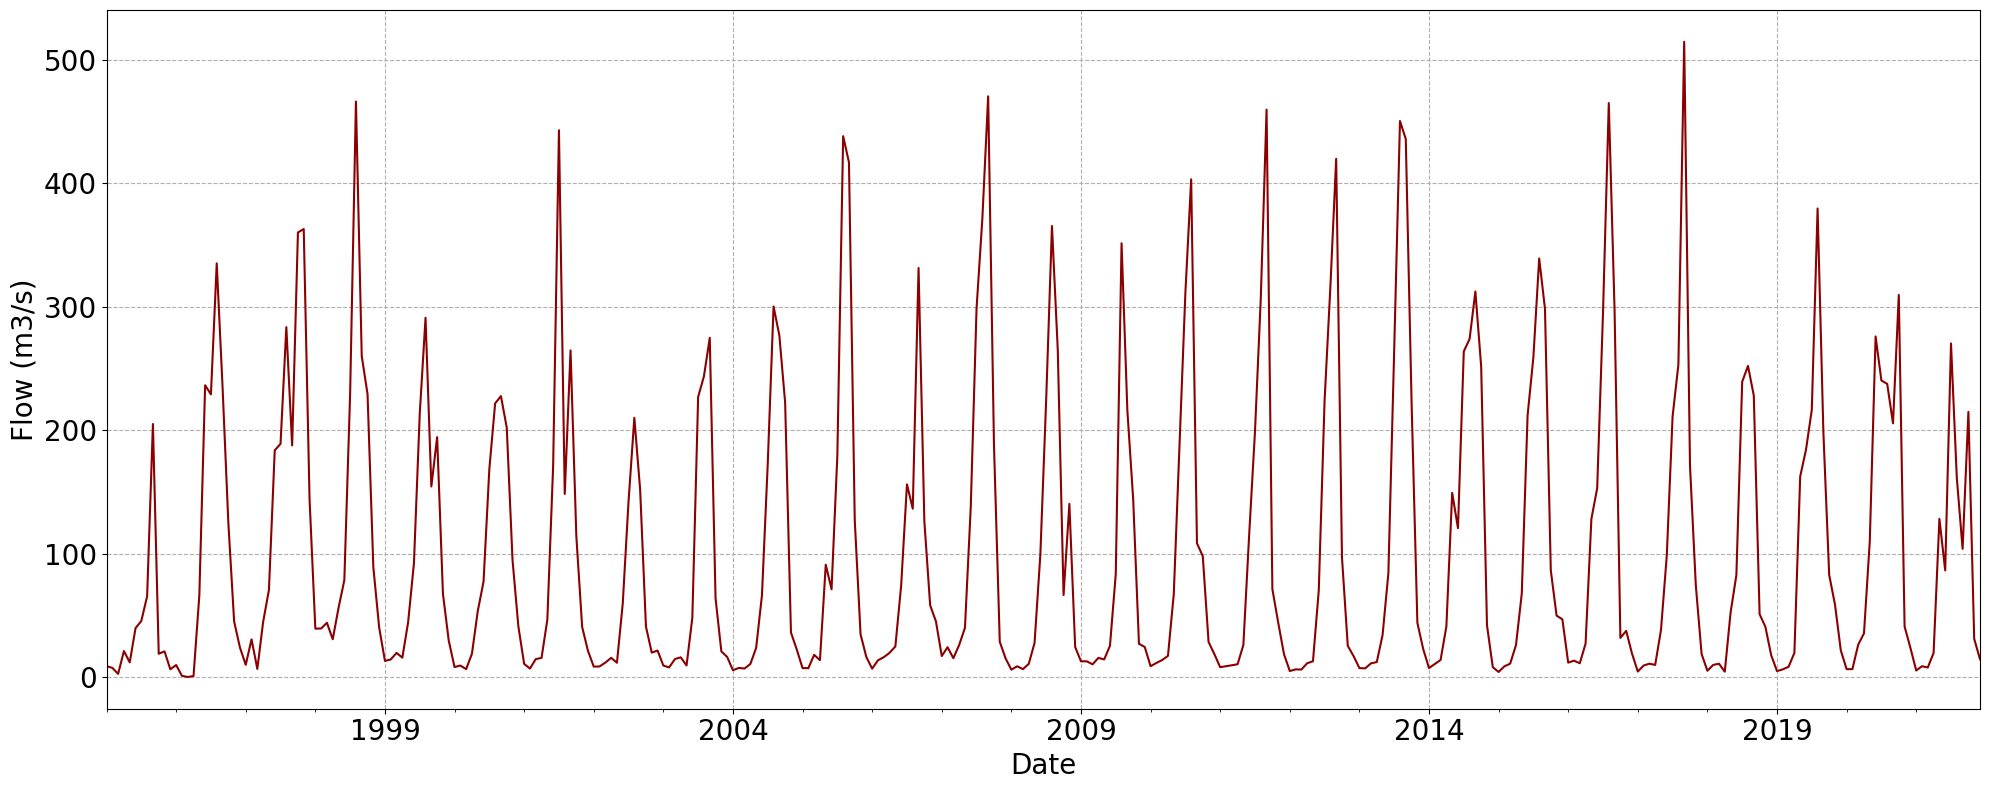

In [52]:

plt.figure(figsize=(20, 8))
flow.plot(x='Date', y='Value', kind='line', ax=plt.gca(), color='#8b0000', fontsize=12)
plt.xlabel('Date', fontdict={'fontsize':20})
plt.ylabel('Flow (m3/s)', fontdict={'fontsize':20})
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.grid(linestyle='--')
plt.tight_layout()
plt.legend().remove()
plt.show()

In [53]:
# Add fuller test to check the stationarity of the dataset
def adfuller_test(values):
    result = adfuller(values)
    labels = ['ADF Test Statistic','p-value','#Lags Used', 'Number of Observations Used']
    for value, label in zip(result, labels):
        print(label+' : '+str(value))
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis(H0)")
    else:
        print("Weak evidence against the null hypothesis(H0)")

In [54]:
# H0: It is non stationary
# H1: It is stationary

In [55]:
adfuller_test(flow['Value'])

ADF Test Statistic : -3.9157577063379865
p-value : 0.0019218914853642902
#Lags Used : 11
Number of Observations Used : 312
Strong evidence against the null hypothesis(H0)


In [56]:
flow = flow[['Date', 'Value']]
flow.set_index('Date', inplace=True)
flow.head()

Value
Date              
1995-01-01   8.735
1995-02-01   7.436
1995-03-01   2.539
1995-04-01  21.051
1995-05-01  11.863

In [57]:
flow_model_names = []
flow_mae_values = []
flow_rmse_values = []
flow_r2_values = []
flow_nse_values = []
flow_willmott_values = []

### TRAIN THE MODELS

In [58]:
# Assuming `temp_max` is your time series DataFrame
series = flow
values = series.values
values = add_rolling_features(values, window=3)
values = pd.DataFrame(values).values
scaler = StandardScaler()
values = scaler.fit_transform(values)
data = series_to_supervised(values, n_in=6)
data_df = pd.DataFrame(data, index=series.index[6+2:])

>expected=0.5, predicted=0.1
>expected=0.5, predicted=0.2
>expected=-0.6, predicted=0.2
>expected=0.8, predicted=0.9
>expected=0.7, predicted=0.2
>expected=1.6, predicted=1.5
>expected=0.3, predicted=0.7
>expected=-0.5, predicted=-0.4
>expected=-0.6, predicted=-0.7
>expected=-0.9, predicted=-0.9
>expected=-0.9, predicted=-1.0
>expected=-0.8, predicted=-0.8
>expected=-0.2, predicted=0.0
>expected=1.1, predicted=0.9
>expected=0.5, predicted=0.7
>expected=-0.7, predicted=-0.5
>expected=-0.7, predicted=-0.1
>expected=-0.1, predicted=0.5
>expected=1.4, predicted=0.4
>expected=1.8, predicted=1.5
>expected=-0.7, predicted=-0.6
>expected=-0.9, predicted=-0.9
>expected=-1.0, predicted=-1.0
>expected=-1.0, predicted=-1.0
>expected=0.1, predicted=-0.2
>expected=-0.1, predicted=0.0
>expected=0.7, predicted=0.5
>expected=0.6, predicted=0.4
>expected=0.4, predicted=0.2
>expected=-0.1, predicted=0.1
>expected=0.6, predicted=0.4
>expected=0.9, predicted=0.7
>expected=0.5, predicted=0.1
>expected=0.5, 

>expected=0.9, predicted=0.7
>expected=0.5, predicted=0.2
>expected=0.5, predicted=0.5
>expected=-0.6, predicted=-0.0
>expected=0.8, predicted=0.2
>expected=0.7, predicted=0.8
>expected=1.6, predicted=1.6
>expected=0.3, predicted=0.6
>expected=-0.5, predicted=-0.5
>expected=-0.6, predicted=-0.8
>expected=-0.9, predicted=-1.0
>expected=-0.9, predicted=-1.0
>expected=-0.8, predicted=-0.8
>expected=-0.2, predicted=-0.3
>expected=1.1, predicted=1.1
>expected=0.5, predicted=0.6
>expected=-0.7, predicted=-0.0
>expected=-0.7, predicted=0.1
>expected=-0.1, predicted=0.3
>expected=1.4, predicted=0.6
>expected=1.8, predicted=1.0
>expected=-0.7, predicted=-0.5
>expected=-0.9, predicted=-0.8
>expected=-1.0, predicted=-0.9
>expected=-1.0, predicted=-1.0
>expected=0.1, predicted=-0.3
>expected=-0.1, predicted=-0.2
>expected=0.7, predicted=0.4
>expected=0.6, predicted=0.1
>expected=0.4, predicted=0.3
>expected=-0.1, predicted=-0.3
>expected=0.6, predicted=-0.0
>expected=0.9, predicted=0.3
>expected=0

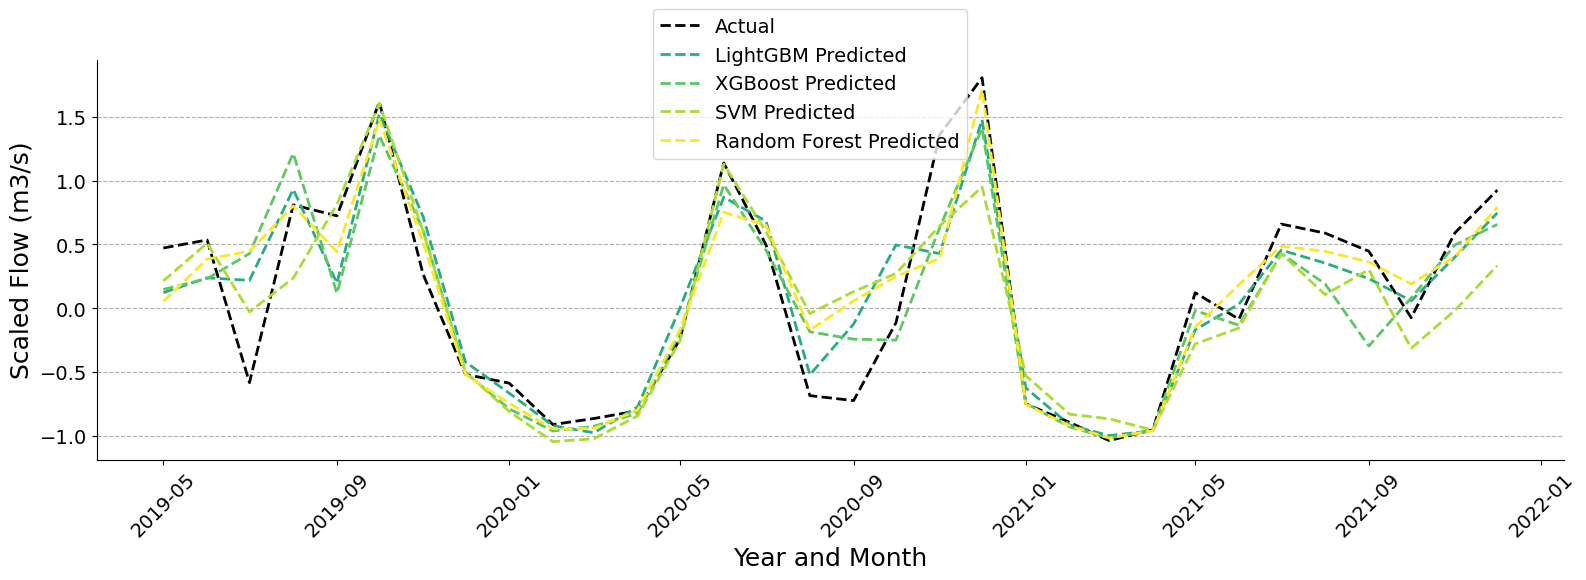

In [59]:

# Model names
models = [
    ('LightGBM', lightgbm_forecast),
    ('XGBoost', xgboost_forecast),
    ('SVM', svm_forecast),
    ('Random Forest', random_forest_forecast)
]

# Clear existing lists in case they contain previous values
model_names.clear()
mae_values.clear()
rmse_values.clear()
r2_values.clear()
nse_values.clear()
willmott_values.clear()

# Iterate over each model, perform walk-forward validation, and append metrics to lists
for model_name, model_func in models:
    mae, rmse, r2, nse, willmott, test_index, y, yhat = walk_forward_validation(data_df, model_func)
    
    model_names.append(model_name)
    mae_values.append(mae)
    rmse_values.append(rmse)
    r2_values.append(r2)
    nse_values.append(nse)
    willmott_values.append(willmott)

# Create a DataFrame
metrics = {
    'Model': model_names,
    'MAE': mae_values,
    'RMSE': rmse_values,
    'R-squared': r2_values,
    'Nash-Sutcliffe Efficiency': nse_values,
    'Willmott\'s Index of Agreement': willmott_values
}

metrics_df = pd.DataFrame(metrics)

# Plot the actual vs predicted values for each model
plt.figure(figsize=(16, 6))
plt.plot(test_index, y, label='Actual', linestyle='--', color='black', linewidth=2)



for model_name, model_func in models:
    _, _, _, _, _, test_index, _, yhat = walk_forward_validation(data_df, model_func)
    plt.plot(test_index, yhat, label=f'{model_name} Predicted', linestyle='--', color=colors_dict[model_name], linewidth=2)

plt.xlabel('Year and Month', fontsize=18)
plt.ylabel('Scaled Flow (m3/s)', fontsize=18)

plt.legend(fontsize=14, loc='upper right', bbox_to_anchor=(0.6, 1.15), ncol=1)

plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)

plt.grid(axis='y', linestyle='--')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

### EVALUATE THE MODEL

In [60]:
# Create a DataFrame
metrics = {
    'Model': model_names,
    'MAE': mae_values,
    'RMSE': rmse_values,
    'R-squared': r2_values,
    'Nash-Sutcliffe Efficiency': nse_values,
    'Willmott\'s Index of Agreement': willmott_values
}

metrics = pd.DataFrame(metrics)

In [61]:
metrics

Model       MAE      RMSE  R-squared  Nash-Sutcliffe Efficiency  \
0       LightGBM  0.251519  0.336681   0.823571                   0.823571   
1        XGBoost  0.257676  0.357689   0.800866                   0.800866   
2            SVM  0.287994  0.386812   0.767119                   0.767119   
3  Random Forest  0.251434  0.344577   0.815198                   0.815198   

   Willmott's Index of Agreement  
0                       0.947015  
1                       0.941150  
2                       0.926692  
3                       0.944750

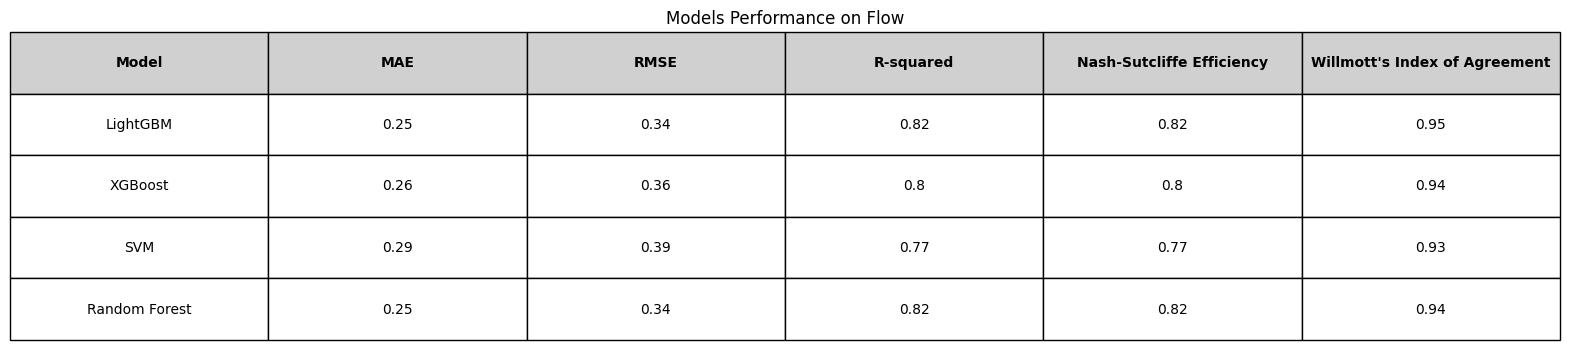

In [62]:
metrics = metrics.round(2)

fig, ax = plt.subplots(figsize=(20, 4))
ax.axis('off')

table = ax.table(cellText=metrics.values,
                 colLabels=metrics.columns,
                 cellLoc='center',
                 loc='center',
                 bbox=[0, 0, 1, 1])

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

header_color = '#D0D0D0'
data_color = '#FFFFFF'

for i, key in enumerate(table._cells):
    cell = table._cells[key]
    cell.set_edgecolor('black')
    if key[0] == 0 or key[1] == -1:
        cell.set_text_props(weight='bold')
        cell.set_facecolor(header_color)
    else:
        cell.set_facecolor(data_color)

plt.title('Models Performance on Flow')
plt.show()


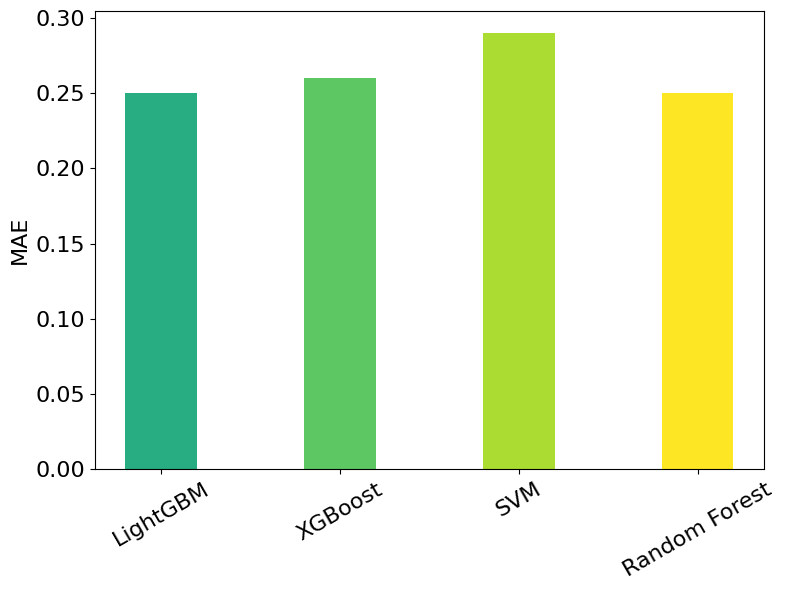

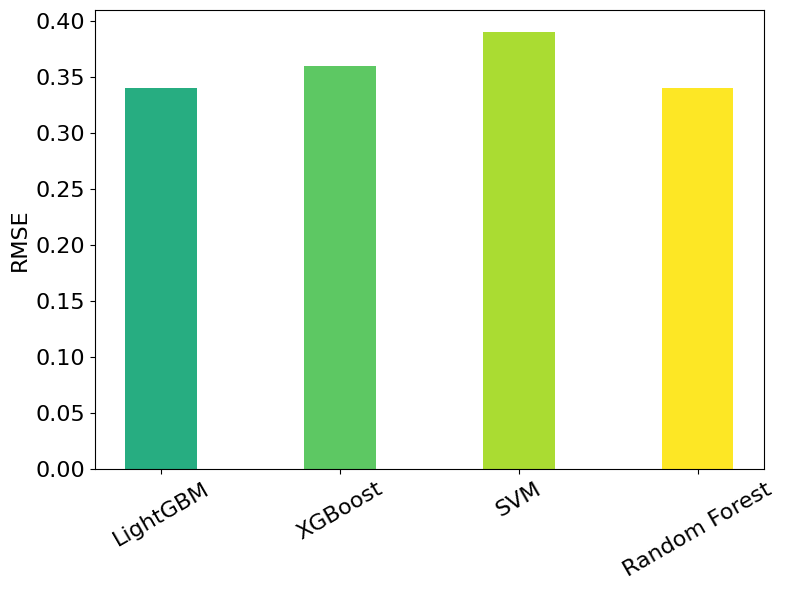

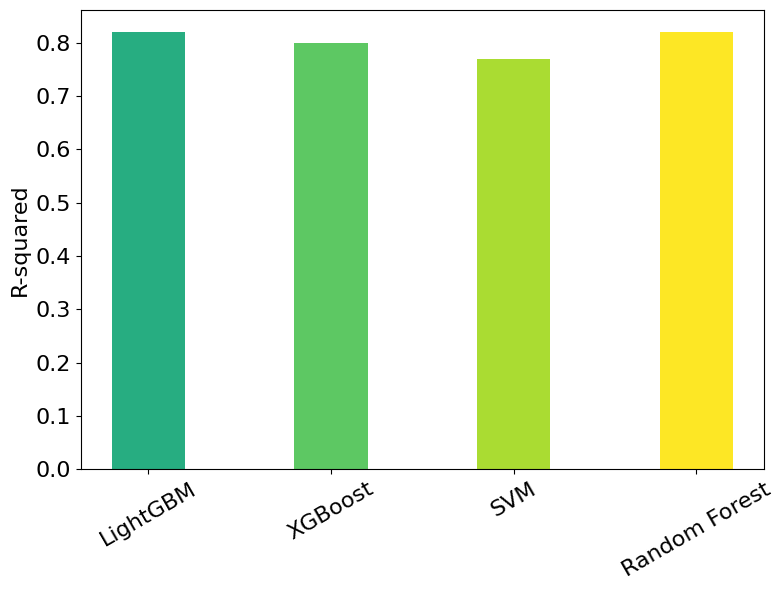

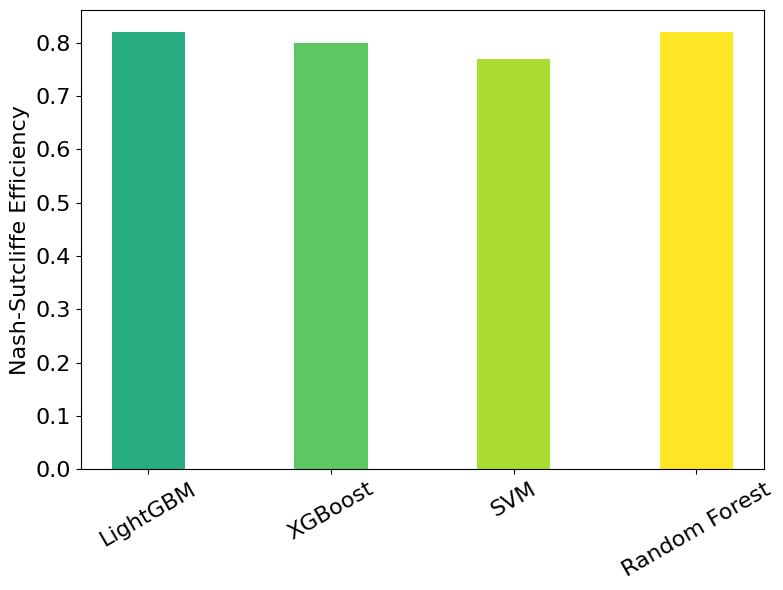

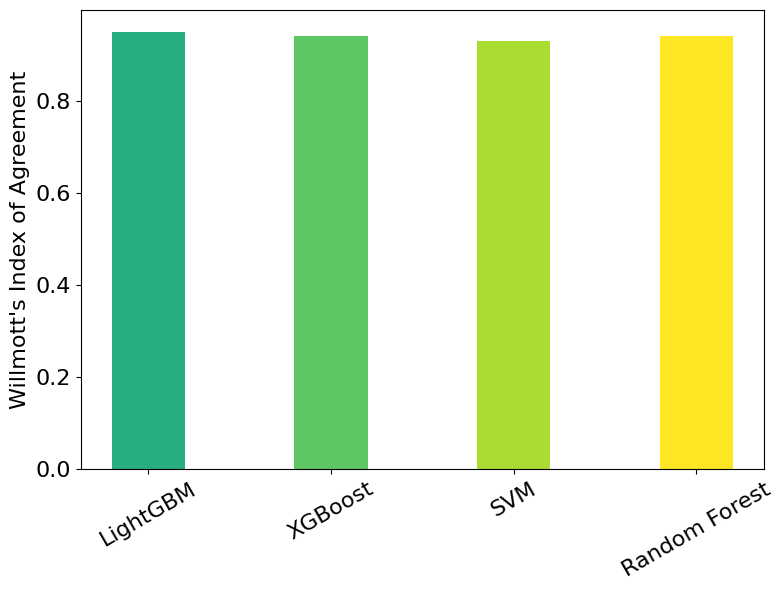

In [63]:

colors = ['#27ad81', '#5dc863', '#aadc32', '#fde725']
bar_width = 0.4

# Metrics and Titles
metrics_title = {
    'MAE': 'Mean Absolute Error (MAE)',
    'RMSE': 'Root Mean Squared Error (RMSE)',
    'R-squared': 'R-squared',
    'Nash-Sutcliffe Efficiency': 'Nash-Sutcliffe Efficiency',
    'Willmott\'s Index of Agreement': 'Willmott\'s Index of Agreement'
}

# Plot each metric separately
for metric, title in metrics_title.items():
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.bar(metrics['Model'], metrics[metric], color=colors, width=bar_width)
    # ax.set_title(title, fontsize=16)
    ax.set_ylabel(metric, fontsize=16)
    ax.tick_params(axis='x', rotation=30, labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    plt.tight_layout()
    plt.show()

## 8. MAX FLOW ANALYSIS

In [64]:
# Get the temp_max values
flow_max = transformed_data[transformed_data['Parameter'] == parameters[2]]
flow_max.head()

Parameter       Date   Value
2   Max FLow 1995-01-01   4.548
7   Max FLow 1996-01-01   9.443
12  Max FLow 1997-01-01   4.839
17  Max FLow 1998-01-01  19.245
22  Max FLow 1999-01-01   7.722

In [65]:
# drop the parameter columns
flow_max = flow_max.drop(columns=['Parameter'])

In [66]:
flow_max.head()

Date   Value
2  1995-01-01   4.548
7  1996-01-01   9.443
12 1997-01-01   4.839
17 1998-01-01  19.245
22 1999-01-01   7.722

In [67]:
# sort according to  the date
flow_max= flow_max.sort_values(by='Date')
flow_max.head()

Date   Value
2   1995-01-01   4.548
137 1995-02-01   4.548
272 1995-03-01   6.800
407 1995-04-01  22.146
542 1995-05-01  31.774

In [68]:
flow_max.head()

Date   Value
2   1995-01-01   4.548
137 1995-02-01   4.548
272 1995-03-01   6.800
407 1995-04-01  22.146
542 1995-05-01  31.774

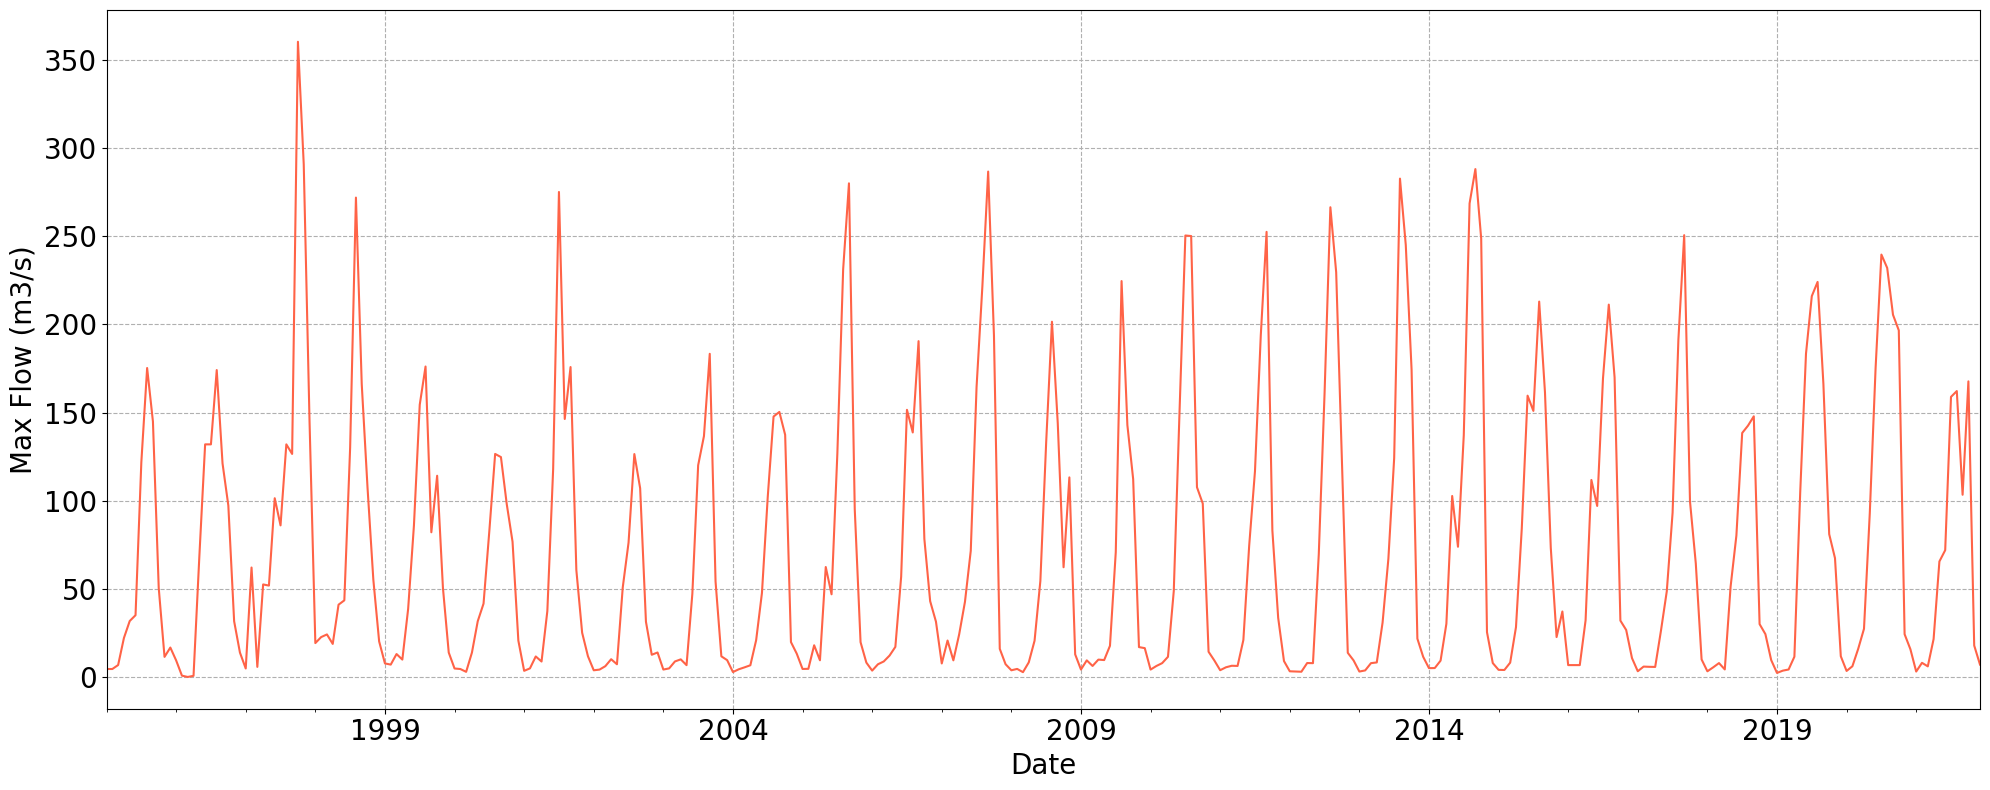

In [69]:
plt.figure(figsize=(20, 8))
flow_max.plot(x='Date', y='Value', kind='line', ax=plt.gca(), color='#ff6347', fontsize=12)
plt.xlabel('Date', fontdict={'fontsize':20})
plt.ylabel('Max Flow (m3/s)', fontdict={'fontsize':20})
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.grid(linestyle='--')
plt.tight_layout()
plt.legend().remove()
plt.show()

In [70]:
# Add fuller test to check the stationarity of the dataset
def adfuller_test(values):
    result = adfuller(values)
    labels = ['ADF Test Statistic','p-value','#Lags Used', 'Number of Observations Used']
    for value, label in zip(result, labels):
        print(label+' : '+str(value))
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis(H0)")
    else:
        print("Weak evidence against the null hypothesis(H0)")

In [71]:
# H0: It is non stationary
# H1: It is stationary

In [72]:
adfuller_test(flow_max['Value'])

ADF Test Statistic : -3.3348205010962766
p-value : 0.013391956092490444
#Lags Used : 11
Number of Observations Used : 312
Strong evidence against the null hypothesis(H0)


In [73]:
flow_max = flow_max[['Date', 'Value']]
flow_max.set_index('Date', inplace=True)
flow_max.head()

Value
Date              
1995-01-01   4.548
1995-02-01   4.548
1995-03-01   6.800
1995-04-01  22.146
1995-05-01  31.774

### TRAIN THE MODEL

In [74]:
# Assuming `flow_max` is your time series DataFrame
series = flow_max
values = series.values
values = add_rolling_features(values, window=3)
values = pd.DataFrame(values).values
scaler = StandardScaler()
values = scaler.fit_transform(values)
data = series_to_supervised(values, n_in=6)
data_df = pd.DataFrame(data, index=series.index[6+2:])

>expected=0.5, predicted=-0.0
>expected=1.4, predicted=1.1
>expected=0.6, predicted=0.9
>expected=-0.5, predicted=1.1
>expected=-0.2, predicted=1.1
>expected=1.0, predicted=1.8
>expected=0.5, predicted=1.1
>expected=-0.0, predicted=0.2
>expected=-0.1, predicted=-0.3
>expected=-1.0, predicted=-0.9
>expected=-0.9, predicted=-1.0
>expected=-0.8, predicted=-0.8
>expected=0.1, predicted=0.0
>expected=1.1, predicted=0.9
>expected=1.1, predicted=1.5
>expected=-0.1, predicted=0.7
>expected=-0.6, predicted=0.8
>expected=-0.6, predicted=1.6
>expected=1.9, predicted=1.9
>expected=1.9, predicted=1.8
>expected=-0.8, predicted=-0.6
>expected=-0.9, predicted=-1.0
>expected=-1.1, predicted=-1.0
>expected=-0.9, predicted=-0.9
>expected=-0.2, predicted=-0.4
>expected=-0.3, predicted=-0.1
>expected=0.4, predicted=0.5
>expected=0.4, predicted=0.4
>expected=-0.1, predicted=-0.4
>expected=-0.1, predicted=-0.1
>expected=1.1, predicted=0.9
>expected=1.6, predicted=0.8
>expected=0.5, predicted=0.2
>expected=1.

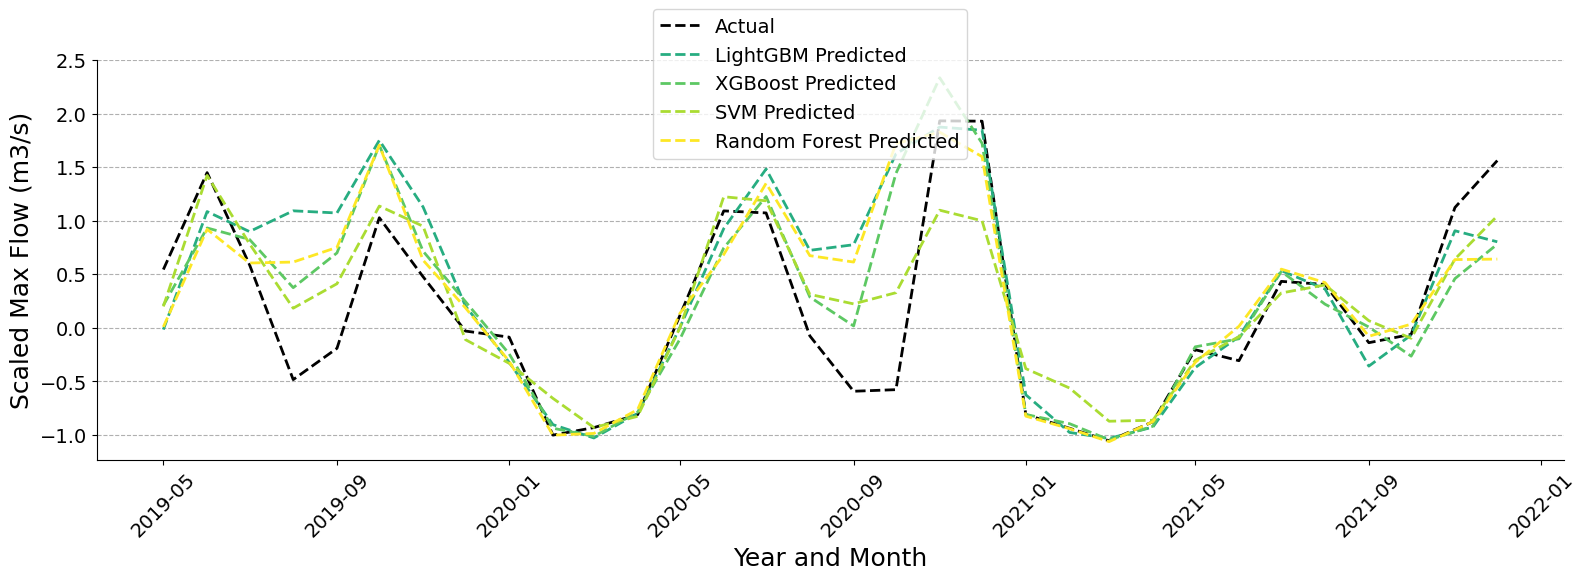

In [75]:

# Model names
models = [
    ('LightGBM', lightgbm_forecast),
    ('XGBoost', xgboost_forecast),
    ('SVM', svm_forecast),
    ('Random Forest', random_forest_forecast)
]

# Clear existing lists in case they contain previous values
model_names.clear()
mae_values.clear()
rmse_values.clear()
r2_values.clear()
nse_values.clear()
willmott_values.clear()

# Iterate over each model, perform walk-forward validation, and append metrics to lists
for model_name, model_func in models:
    mae, rmse, r2, nse, willmott, test_index, y, yhat = walk_forward_validation(data_df, model_func)
    
    model_names.append(model_name)
    mae_values.append(mae)
    rmse_values.append(rmse)
    r2_values.append(r2)
    nse_values.append(nse)
    willmott_values.append(willmott)

# Create a DataFrame
metrics = {
    'Model': model_names,
    'MAE': mae_values,
    'RMSE': rmse_values,
    'R-squared': r2_values,
    'Nash-Sutcliffe Efficiency': nse_values,
    'Willmott\'s Index of Agreement': willmott_values
}

metrics_df = pd.DataFrame(metrics)

# Plot the actual vs predicted values for each model
plt.figure(figsize=(16, 6))
plt.plot(test_index, y, label='Actual', linestyle='--', color='black', linewidth=2)



for model_name, model_func in models:
    _, _, _, _, _, test_index, _, yhat = walk_forward_validation(data_df, model_func)
    plt.plot(test_index, yhat, label=f'{model_name} Predicted', linestyle='--', color=colors_dict[model_name], linewidth=2)

plt.xlabel('Year and Month', fontsize=18)
plt.ylabel('Scaled Max Flow (m3/s)', fontsize=18)

plt.legend(fontsize=14, loc='upper right', bbox_to_anchor=(0.6, 1.15), ncol=1)

plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.grid(axis='y', linestyle='--')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

### EVALUATE THE MODEL

In [76]:
# Create a DataFrame
metrics = {
    'Model': model_names,
    'MAE': mae_values,
    'RMSE': rmse_values,
    'R-squared': r2_values,
    'Nash-Sutcliffe Efficiency': nse_values,
    'Willmott\'s Index of Agreement': willmott_values
}

metrics = pd.DataFrame(metrics)

In [77]:
metrics

Model       MAE      RMSE  R-squared  Nash-Sutcliffe Efficiency  \
0       LightGBM  0.417202  0.663100   0.421248                   0.421248   
1        XGBoost  0.345963  0.523519   0.639255                   0.639255   
2            SVM  0.312871  0.418174   0.769830                   0.769830   
3  Random Forest  0.372875  0.616156   0.500292                   0.500292   

   Willmott's Index of Agreement  
0                       0.860371  
1                       0.905622  
2                       0.924929  
3                       0.866312

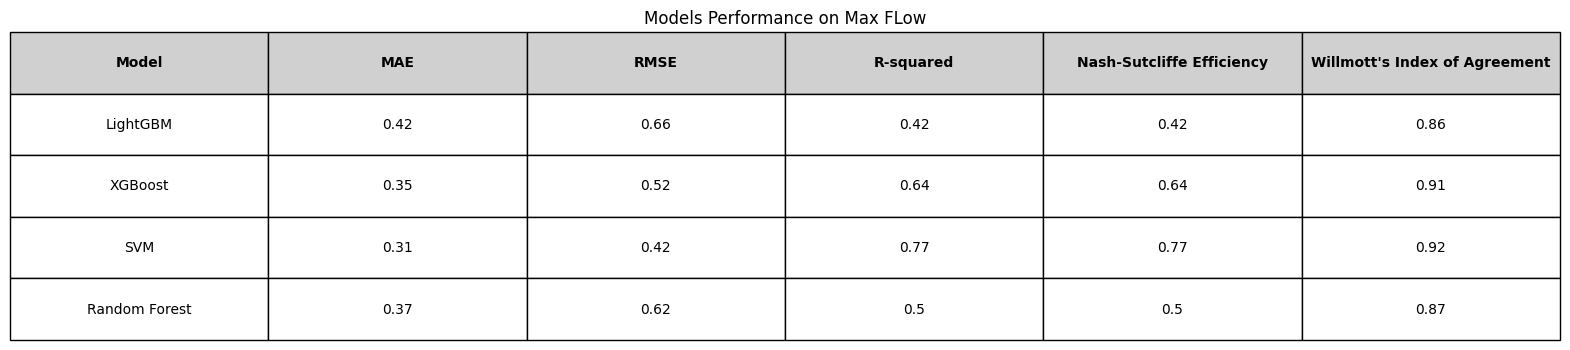

In [78]:
metrics = metrics.round(2)

fig, ax = plt.subplots(figsize=(20, 4))
ax.axis('off')

table = ax.table(cellText=metrics.values,
                 colLabels=metrics.columns,
                 cellLoc='center',
                 loc='center',
                 bbox=[0, 0, 1, 1])

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

header_color = '#D0D0D0'
data_color = '#FFFFFF'

for i, key in enumerate(table._cells):
    cell = table._cells[key]
    cell.set_edgecolor('black')
    if key[0] == 0 or key[1] == -1:
        cell.set_text_props(weight='bold')
        cell.set_facecolor(header_color)
    else:
        cell.set_facecolor(data_color)

plt.title('Models Performance on Max FLow')
plt.show()


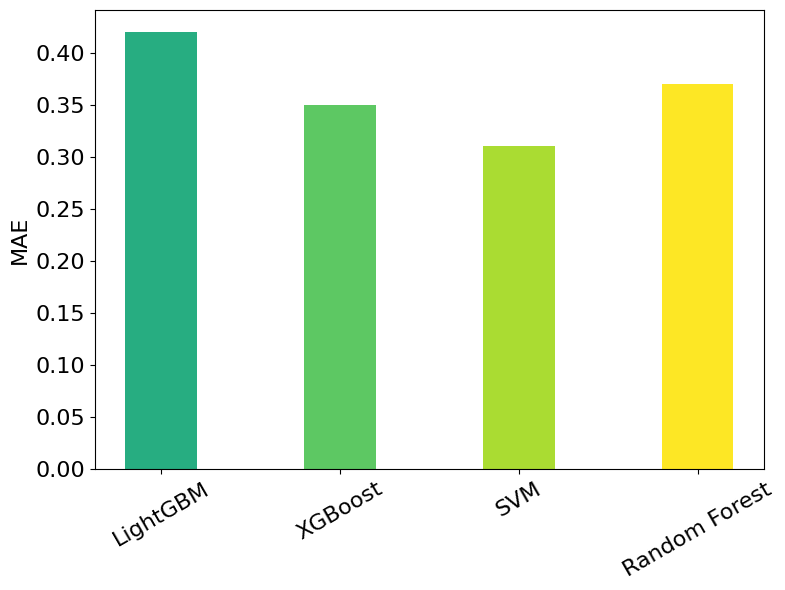

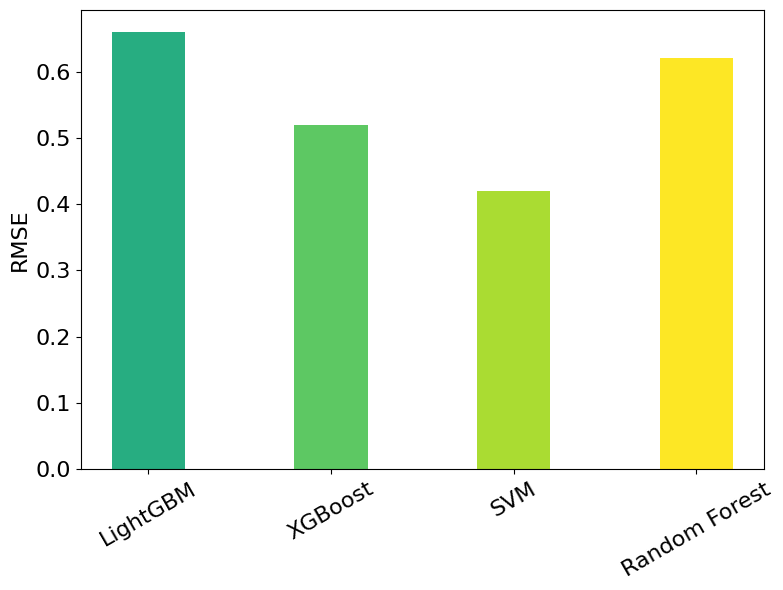

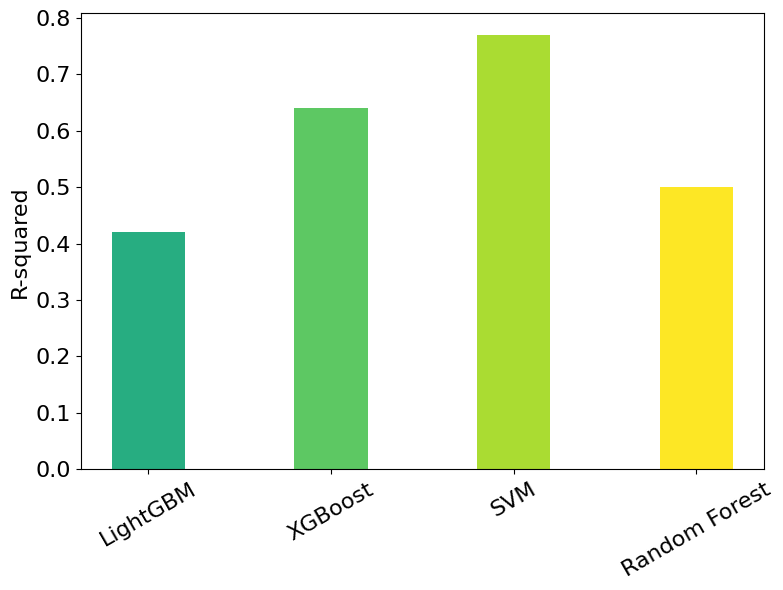

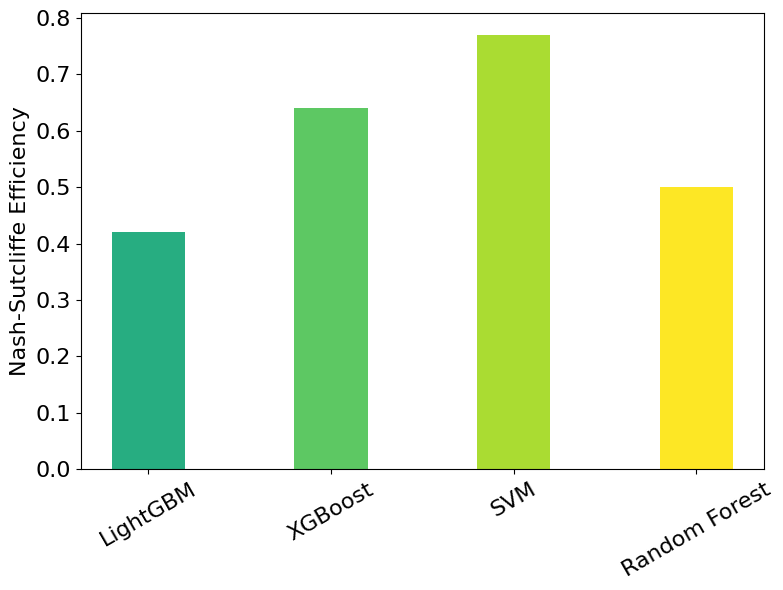

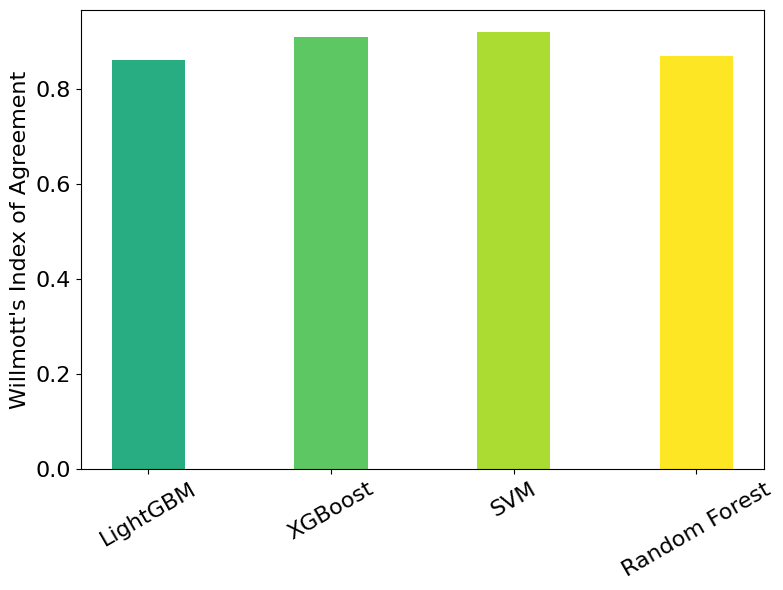

In [79]:

colors = ['#27ad81', '#5dc863', '#aadc32', '#fde725']
bar_width = 0.4

# Metrics and Titles
metrics_title = {
    'MAE': 'Mean Absolute Error (MAE)',
    'RMSE': 'Root Mean Squared Error (RMSE)',
    'R-squared': 'R-squared',
    'Nash-Sutcliffe Efficiency': 'Nash-Sutcliffe Efficiency',
    'Willmott\'s Index of Agreement': 'Willmott\'s Index of Agreement'
}

# Plot each metric separately
for metric, title in metrics_title.items():
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.bar(metrics['Model'], metrics[metric], color=colors, width=bar_width)
    # ax.set_title(title, fontsize=16)
    ax.set_ylabel(metric, fontsize=16)
    ax.tick_params(axis='x', rotation=30, labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    plt.tight_layout()
    plt.show()

## 9. MIN FLOW ANALYSIS

In [80]:
flow_min = transformed_data[transformed_data['Parameter']=='Min Flow']

In [81]:
# drop the parameter columns
flow_min = flow_min.drop(columns=['Parameter'])

In [82]:
flow_min.head()

Date   Value
3  1995-01-01   2.226
8  1996-01-01   9.574
13 1997-01-01   5.943
18 1998-01-01  24.986
23 1999-01-01   9.093

In [83]:
# sort according to  the date
flow_min = flow_min.sort_values(by='Date')
flow_min.head()

Date   Value
3   1995-01-01   2.226
138 1995-02-01   2.456
273 1995-03-01   4.548
408 1995-04-01   1.586
543 1995-05-01  16.041

In [84]:
flow_min.head()

Date   Value
3   1995-01-01   2.226
138 1995-02-01   2.456
273 1995-03-01   4.548
408 1995-04-01   1.586
543 1995-05-01  16.041

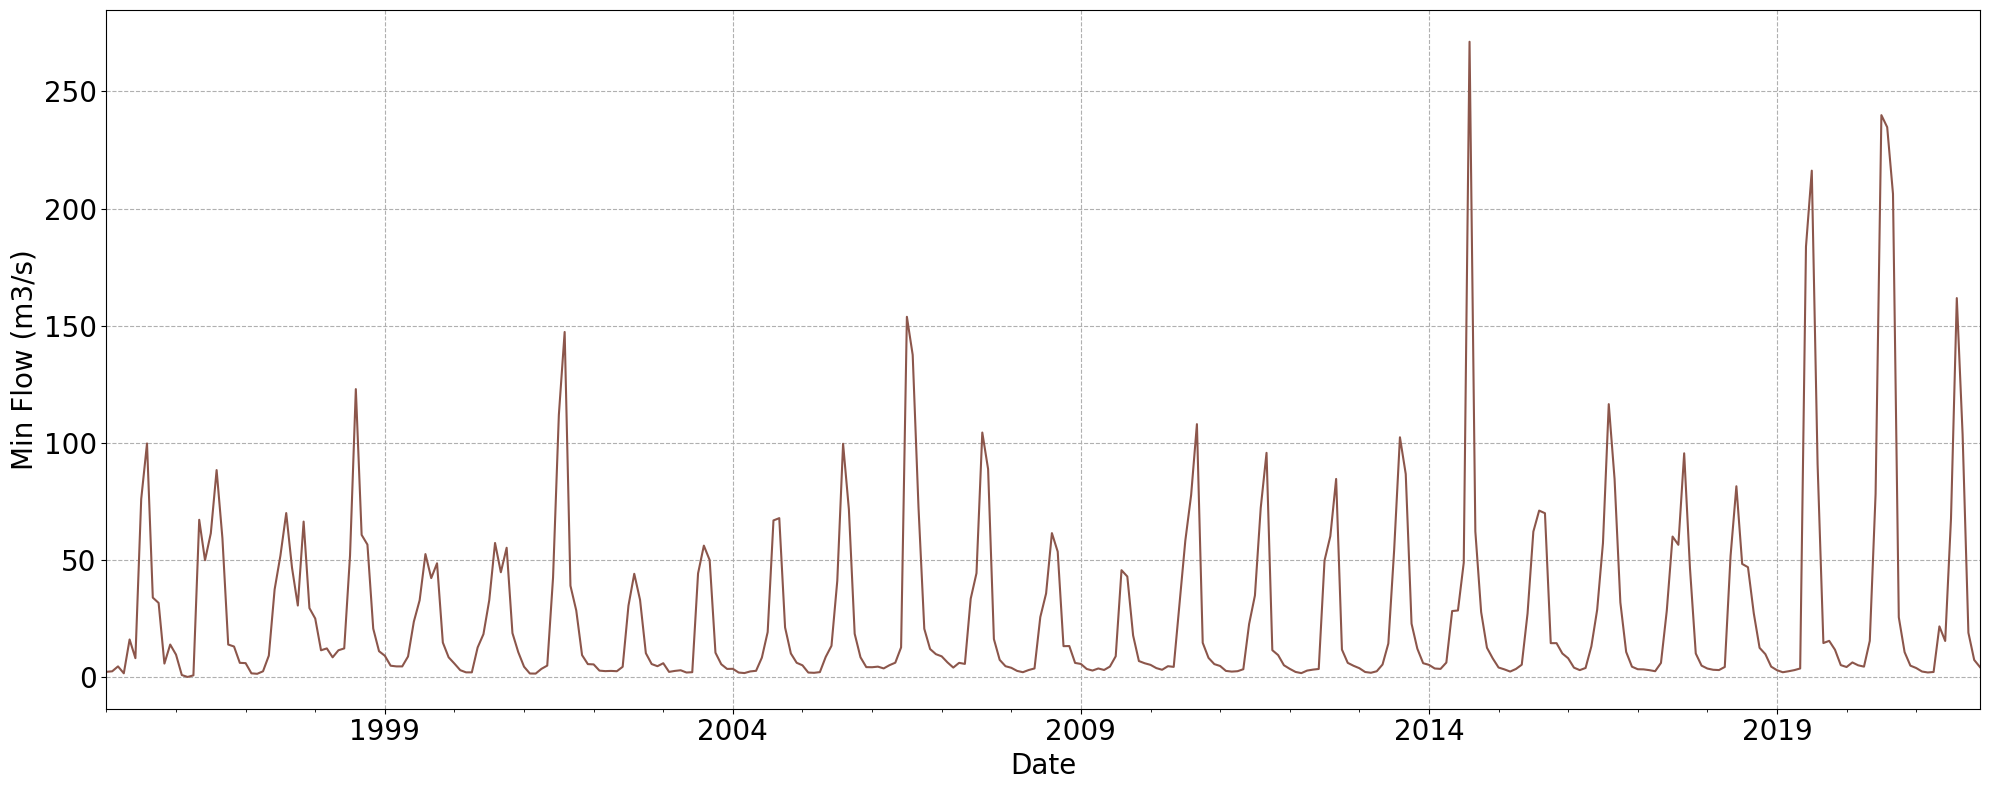

In [85]:
plt.figure(figsize=(20, 8))
flow_min.plot(x='Date', y='Value', kind='line', ax=plt.gca(), color='#8c564b', fontsize=12)
plt.xlabel('Date', fontdict={'fontsize':20})
plt.ylabel('Min Flow (m3/s)', fontdict={'fontsize':20})
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.grid(linestyle='--')
plt.tight_layout()
plt.legend().remove()
plt.show()

In [86]:
# Add fuller test to check the stationarity of the dataset
def adfuller_test(values):
    result = adfuller(values)
    labels = ['ADF Test Statistic','p-value','#Lags Used', 'Number of Observations Used']
    for value, label in zip(result, labels):
        print(label+' : '+str(value))
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis(H0)")
    else:
        print("Weak evidence against the null hypothesis(H0)")

In [87]:
# H0: It is non stationary
# H1: It is stationary

In [88]:
adfuller_test(flow_min['Value'])

ADF Test Statistic : -2.990114823998536
p-value : 0.03582792052802385
#Lags Used : 13
Number of Observations Used : 310
Strong evidence against the null hypothesis(H0)


In [89]:
flow_min = flow_min[['Date', 'Value']]
flow_min.set_index('Date', inplace=True)
flow_min.head()

Value
Date              
1995-01-01   2.226
1995-02-01   2.456
1995-03-01   4.548
1995-04-01   1.586
1995-05-01  16.041

### TRAIN THE MODEL

In [90]:
# Assuming `flow min` is your time series DataFrame
series = flow_min
values = series.values
values = add_rolling_features(values, window=3)
values = pd.DataFrame(values).values
scaler = StandardScaler()
values = scaler.fit_transform(values)
data = series_to_supervised(values, n_in=6)
data_df = pd.DataFrame(data, index=series.index[6+2:])

>expected=-0.7, predicted=-0.7
>expected=3.6, predicted=1.6
>expected=4.0, predicted=1.6
>expected=2.0, predicted=1.2
>expected=3.5, predicted=1.8
>expected=1.1, predicted=1.3
>expected=-0.7, predicted=-0.3
>expected=-0.5, predicted=-0.6
>expected=-0.6, predicted=-0.6
>expected=-0.7, predicted=-0.7
>expected=-0.7, predicted=-0.7
>expected=-0.7, predicted=-0.7
>expected=-0.5, predicted=-0.5
>expected=0.9, predicted=1.0
>expected=4.1, predicted=2.0
>expected=3.1, predicted=1.9
>expected=0.0, predicted=2.1
>expected=4.0, predicted=1.9
>expected=3.8, predicted=2.7
>expected=-0.3, predicted=0.1
>expected=-0.6, predicted=-0.5
>expected=-0.7, predicted=-0.7
>expected=-0.7, predicted=-0.7
>expected=-0.7, predicted=-0.7
>expected=-0.3, predicted=-0.3
>expected=-0.3, predicted=-0.4
>expected=0.4, predicted=0.7
>expected=2.4, predicted=2.8
>expected=1.2, predicted=1.7
>expected=2.3, predicted=2.8
>expected=1.4, predicted=1.2
>expected=-0.4, predicted=-0.5
>expected=-0.7, predicted=-0.7
>expected=

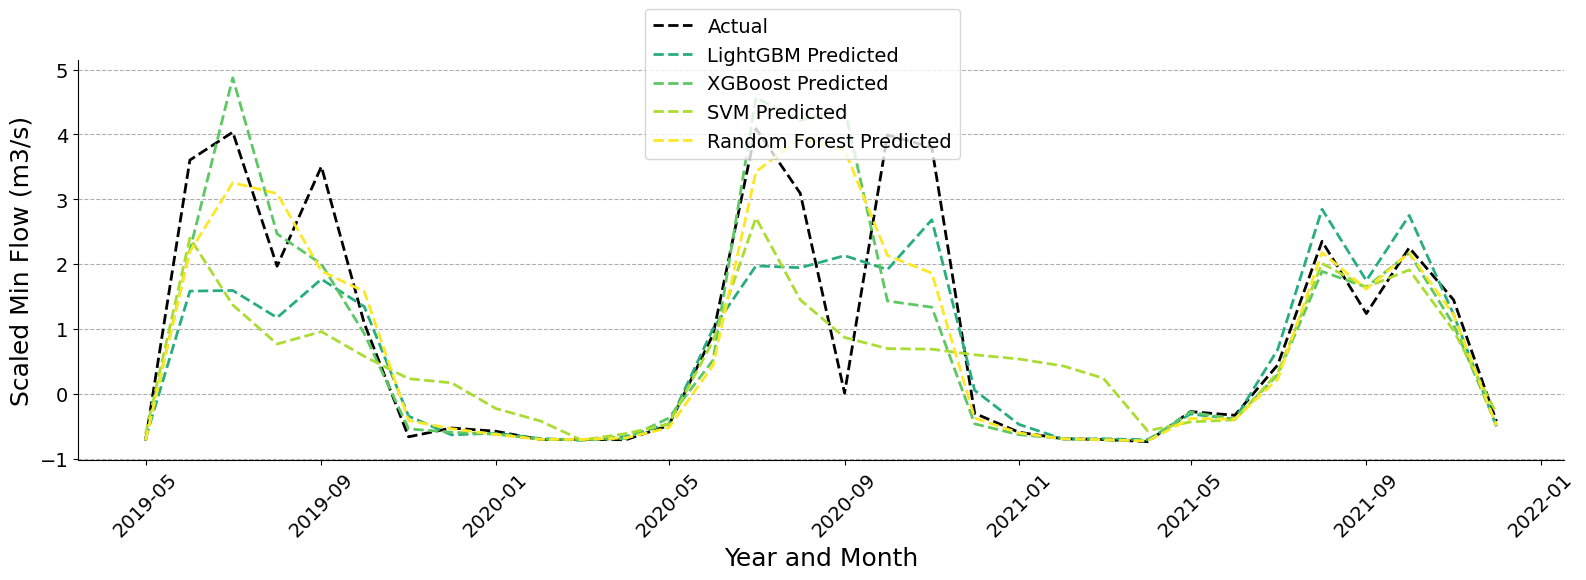

In [91]:
# Model names
models = [
    ('LightGBM', lightgbm_forecast),
    ('XGBoost', xgboost_forecast),
    ('SVM', svm_forecast),
    ('Random Forest', random_forest_forecast)
]

# Clear existing lists in case they contain previous values
model_names.clear()
mae_values.clear()
rmse_values.clear()
r2_values.clear()
nse_values.clear()
willmott_values.clear()

# Iterate over each model, perform walk-forward validation, and append metrics to lists
for model_name, model_func in models:
    mae, rmse, r2, nse, willmott, test_index, y, yhat = walk_forward_validation(data_df, model_func)
    
    model_names.append(model_name)
    mae_values.append(mae)
    rmse_values.append(rmse)
    r2_values.append(r2)
    nse_values.append(nse)
    willmott_values.append(willmott)

# Create a DataFrame
metrics = {
    'Model': model_names,
    'MAE': mae_values,
    'RMSE': rmse_values,
    'R-squared': r2_values,
    'Nash-Sutcliffe Efficiency': nse_values,
    'Willmott\'s Index of Agreement': willmott_values
}

metrics_df = pd.DataFrame(metrics)

# Plot the actual vs predicted values for each model
plt.figure(figsize=(16, 6))
plt.plot(test_index, y, label='Actual', linestyle='--', color='black', linewidth=2)



for model_name, model_func in models:
    _, _, _, _, _, test_index, _, yhat = walk_forward_validation(data_df, model_func)
    plt.plot(test_index, yhat, label=f'{model_name} Predicted', linestyle='--', color=colors_dict[model_name], linewidth=2)

plt.xlabel('Year and Month', fontsize=18)
plt.ylabel('Scaled Min Flow (m3/s)', fontsize=18)

plt.legend(fontsize=14, loc='upper right', bbox_to_anchor=(0.6, 1.15), ncol=1)

plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)

plt.grid(axis='y', linestyle='--')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

### EVALUATE THE MODEL

In [92]:
# Create a DataFrame
metrics = {
    'Model': model_names,
    'MAE': mae_values,
    'RMSE': rmse_values,
    'R-squared': r2_values,
    'Nash-Sutcliffe Efficiency': nse_values,
    'Willmott\'s Index of Agreement': willmott_values
}

metrics = pd.DataFrame(metrics)

In [93]:
metrics

Model       MAE      RMSE  R-squared  Nash-Sutcliffe Efficiency  \
0       LightGBM  0.599431  0.980653   0.687825                   0.687825   
1        XGBoost  0.562869  1.109127   0.600671                   0.600671   
2            SVM  0.852233  1.239082   0.501612                   0.501612   
3  Random Forest  0.550639  1.002738   0.673605                   0.673605   

   Willmott's Index of Agreement  
0                       0.887622  
1                       0.892242  
2                       0.770965  
3                       0.902759

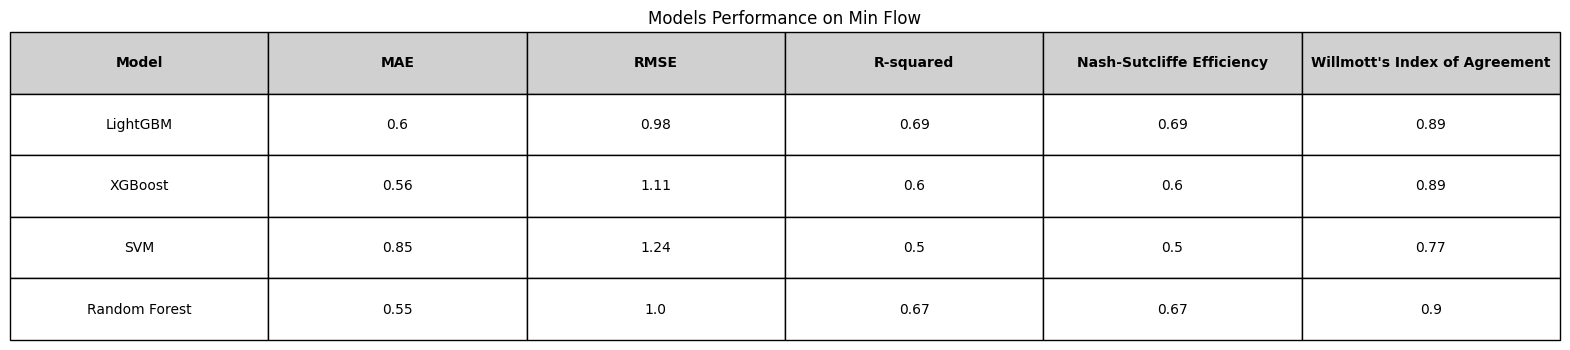

In [94]:
metrics = metrics.round(2)

fig, ax = plt.subplots(figsize=(20, 4))
ax.axis('off')

table = ax.table(cellText=metrics.values,
                 colLabels=metrics.columns,
                 cellLoc='center',
                 loc='center',
                 bbox=[0, 0, 1, 1])

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

header_color = '#D0D0D0'
data_color = '#FFFFFF'

for i, key in enumerate(table._cells):
    cell = table._cells[key]
    cell.set_edgecolor('black')
    if key[0] == 0 or key[1] == -1:
        cell.set_text_props(weight='bold')
        cell.set_facecolor(header_color)
    else:
        cell.set_facecolor(data_color)

plt.title('Models Performance on Min Flow')
plt.show()


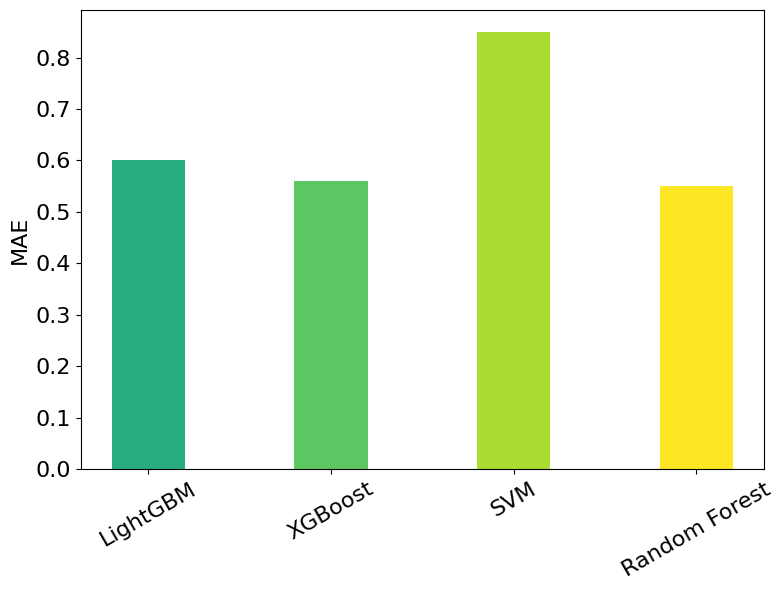

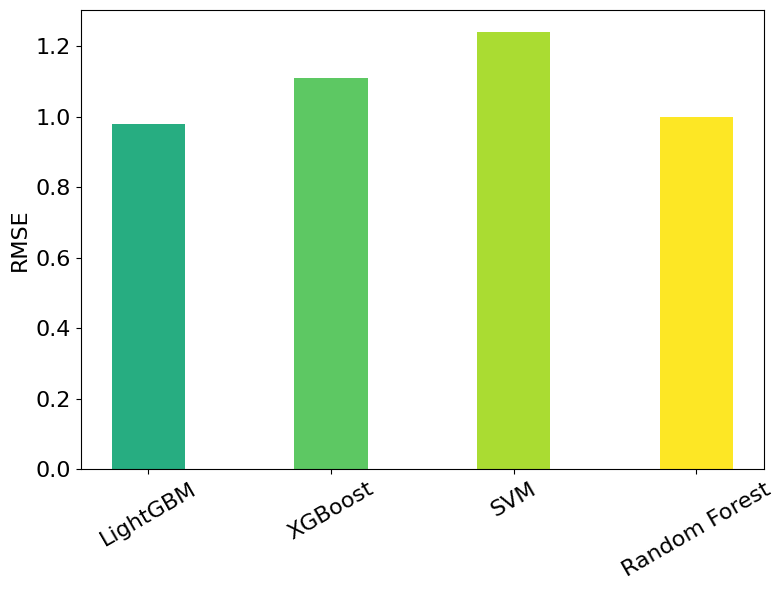

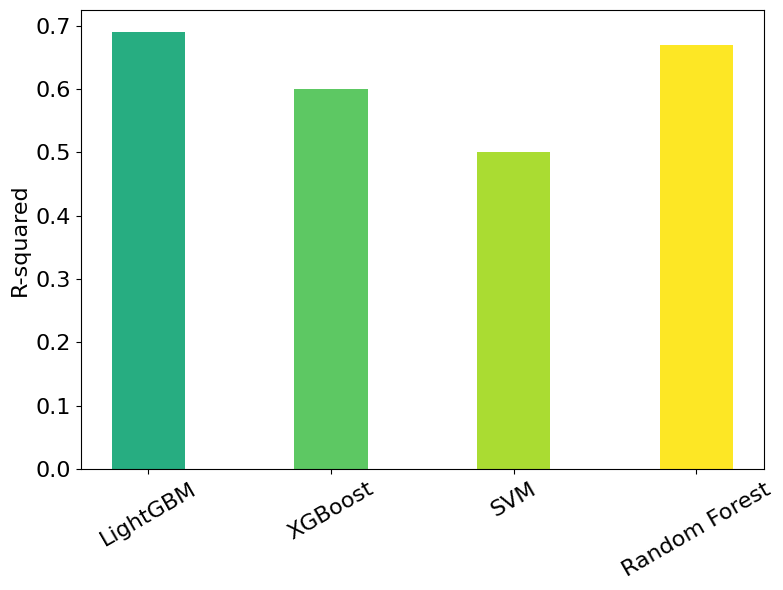

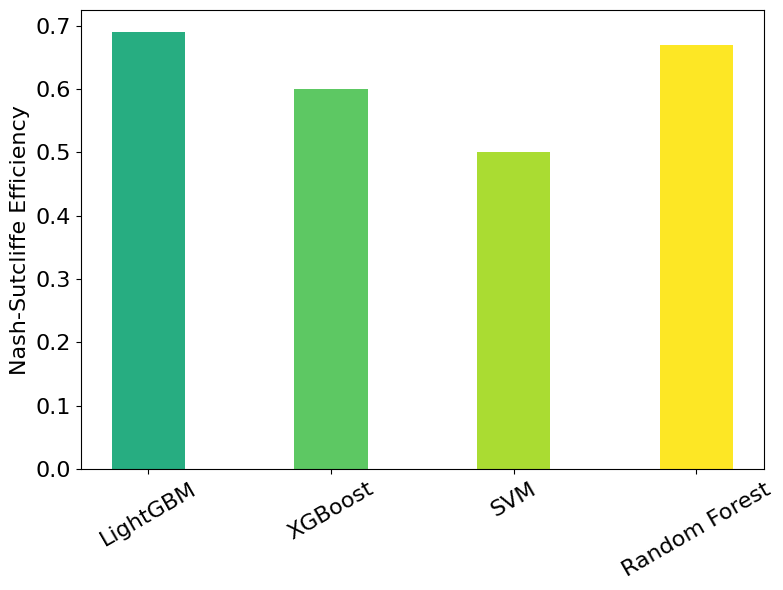

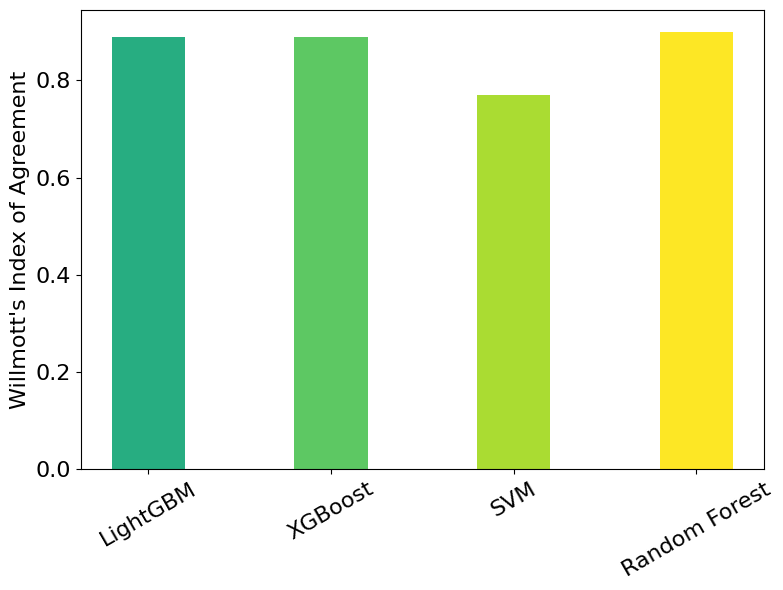

In [95]:

colors = ['#27ad81', '#5dc863', '#aadc32', '#fde725']
bar_width = 0.4

# Metrics and Titles
metrics_title = {
    'MAE': 'Mean Absolute Error (MAE)',
    'RMSE': 'Root Mean Squared Error (RMSE)',
    'R-squared': 'R-squared',
    'Nash-Sutcliffe Efficiency': 'Nash-Sutcliffe Efficiency',
    'Willmott\'s Index of Agreement': 'Willmott\'s Index of Agreement'
}

# Plot each metric separately
for metric, title in metrics_title.items():
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.bar(metrics['Model'], metrics[metric], color=colors, width=bar_width)
    # ax.set_title(title, fontsize=16)
    ax.set_ylabel(metric, fontsize=16)
    ax.tick_params(axis='x', rotation=30, labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    plt.tight_layout()
    plt.show()

## 10. RUNOFF (m3/s) ANALYSIS

In [96]:
# Get the wind_min values
runoff = transformed_data[transformed_data['Parameter'] == parameters[4]]
runoff.head()

Parameter       Date   Value
4     Runoff 1995-01-01   2.945
9     Runoff 1996-01-01   9.508
14    Runoff 1997-01-01   6.325
19    Runoff 1998-01-01  15.325
24    Runoff 1999-01-01  10.231

In [97]:
# drop the parameter columns
runoff = runoff.drop(columns=['Parameter'])

In [98]:
runoff.head()

Date   Value
4  1995-01-01   2.945
9  1996-01-01   9.508
14 1997-01-01   6.325
19 1998-01-01  15.325
24 1999-01-01  10.231

In [99]:
# sort according to  the date
runoff = runoff.sort_values(by='Date')
runoff.head()

Date  Value
4   1995-01-01  2.945
139 1995-02-01  2.507
274 1995-03-01  1.389
409 1995-04-01  7.098
544 1995-05-01  6.384

In [100]:
runoff.head()

Date  Value
4   1995-01-01  2.945
139 1995-02-01  2.507
274 1995-03-01  1.389
409 1995-04-01  7.098
544 1995-05-01  6.384

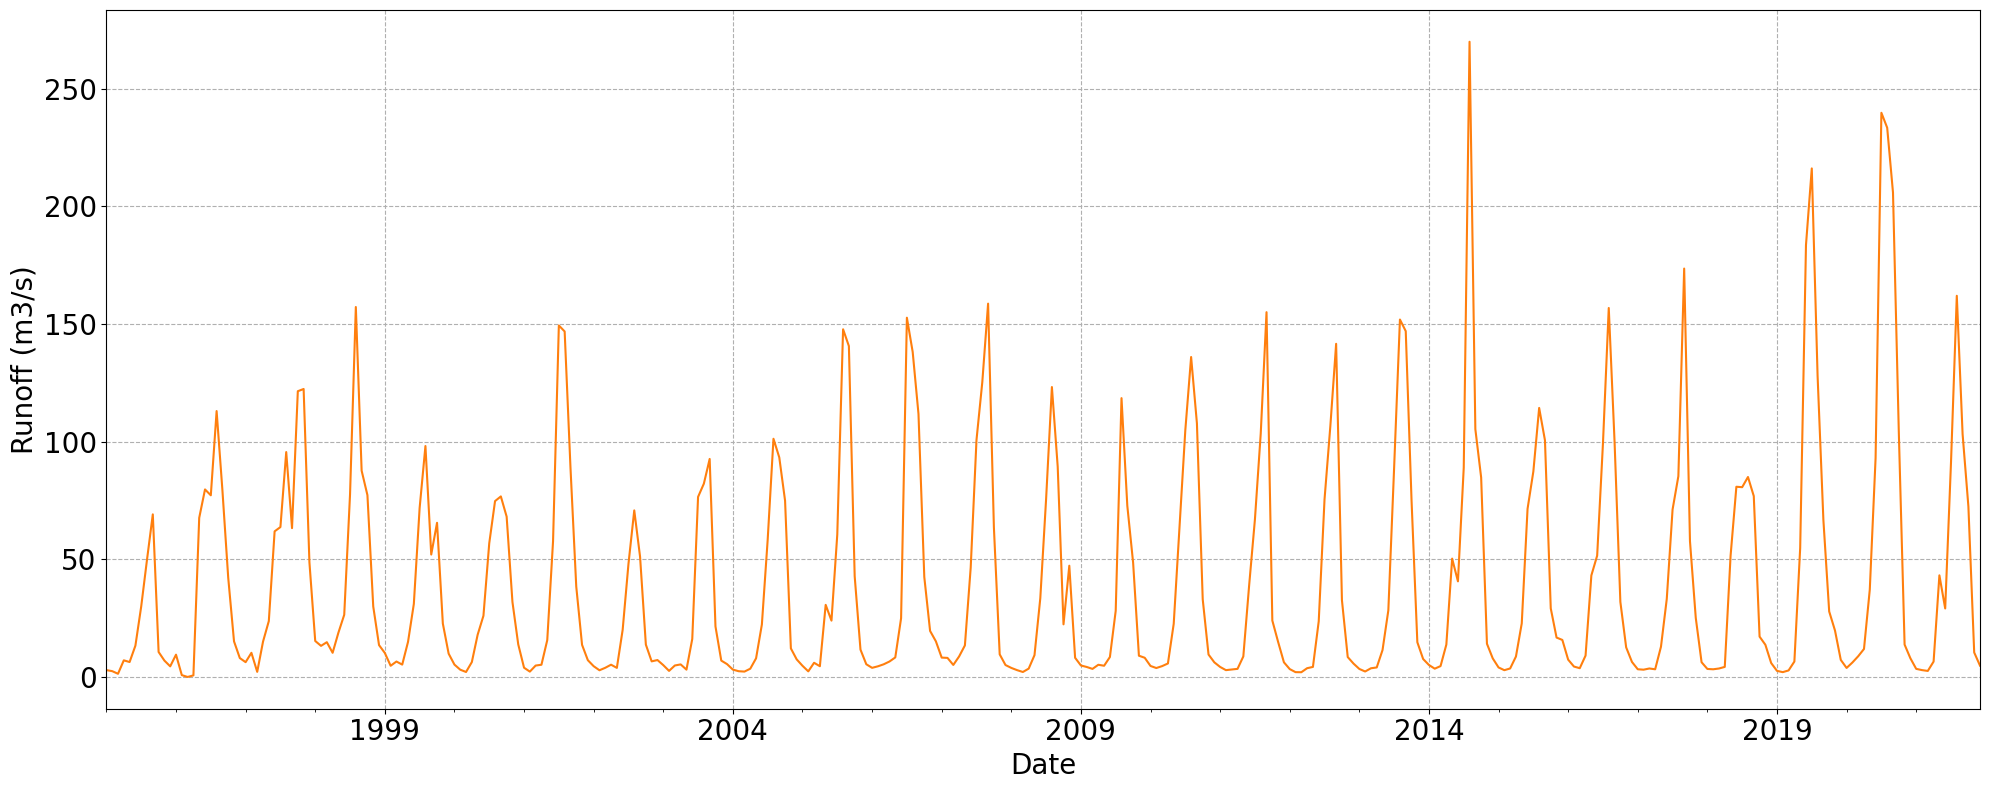

In [101]:
plt.figure(figsize=(20, 8))
runoff.plot(x='Date', y='Value', kind='line', ax=plt.gca(), color='#ff7f0e', fontsize=12)
plt.xlabel('Date', fontdict={'fontsize':20})
plt.ylabel('Runoff (m3/s)', fontdict={'fontsize':20})
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.grid(linestyle='--')
plt.tight_layout()
plt.legend().remove()
plt.show()

In [102]:
# Add fuller test to check the stationarity of the dataset
def adfuller_test(values):
    result = adfuller(values)
    labels = ['ADF Test Statistic','p-value','#Lags Used', 'Number of Observations Used']
    for value, label in zip(result, labels):
        print(label+' : '+str(value))
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis(H0)")
    else:
        print("Weak evidence against the null hypothesis(H0)")

In [103]:
# H0: It is non stationary
# H1: It is stationary

In [104]:
adfuller_test(runoff['Value'])

ADF Test Statistic : -3.1849102477864863
p-value : 0.020874917485704747
#Lags Used : 11
Number of Observations Used : 312
Strong evidence against the null hypothesis(H0)


In [105]:
runoff = runoff[['Date', 'Value']]
runoff.set_index('Date', inplace=True)
runoff.head()

Value
Date             
1995-01-01  2.945
1995-02-01  2.507
1995-03-01  1.389
1995-04-01  7.098
1995-05-01  6.384

In [106]:
runoff_model_names = []
runoff_mae_values = []
runoff_rmse_values = []
runoff_r2_values = []
runoff_nse_values = []
runoff_willmott_values = []

### TRAIN THE MODEL

In [107]:
# Assuming `runoff` is your time series DataFrame
series = runoff
values = series.values
values = add_rolling_features(values, window=3)
values = pd.DataFrame(values).values
scaler = StandardScaler()
values = scaler.fit_transform(values)
data = series_to_supervised(values, n_in=6)
data_df = pd.DataFrame(data, index=series.index[6+2:])

>expected=0.3, predicted=0.2
>expected=3.0, predicted=1.4
>expected=2.7, predicted=1.2
>expected=0.9, predicted=1.6
>expected=2.2, predicted=1.0
>expected=1.2, predicted=1.9
>expected=0.1, predicted=0.5
>expected=-0.5, predicted=-0.6
>expected=-0.6, predicted=-0.7
>expected=-0.9, predicted=-0.9
>expected=-0.9, predicted=-0.9
>expected=-0.9, predicted=-0.8
>expected=-0.3, predicted=-0.2
>expected=0.8, predicted=0.7
>expected=3.5, predicted=1.8
>expected=2.6, predicted=1.6
>expected=-0.2, predicted=2.1
>expected=1.9, predicted=1.3
>expected=3.2, predicted=1.8
>expected=1.3, predicted=1.6
>expected=-0.8, predicted=-0.7
>expected=-0.9, predicted=-0.9
>expected=-1.0, predicted=-0.9
>expected=-0.9, predicted=-0.9
>expected=-0.0, predicted=-0.2
>expected=-0.2, predicted=0.1
>expected=0.4, predicted=0.2
>expected=1.9, predicted=1.7
>expected=0.6, predicted=0.8
>expected=1.0, predicted=1.5
>expected=1.1, predicted=1.6
>expected=0.6, predicted=0.5
>expected=0.3, predicted=0.1
>expected=3.0, pred

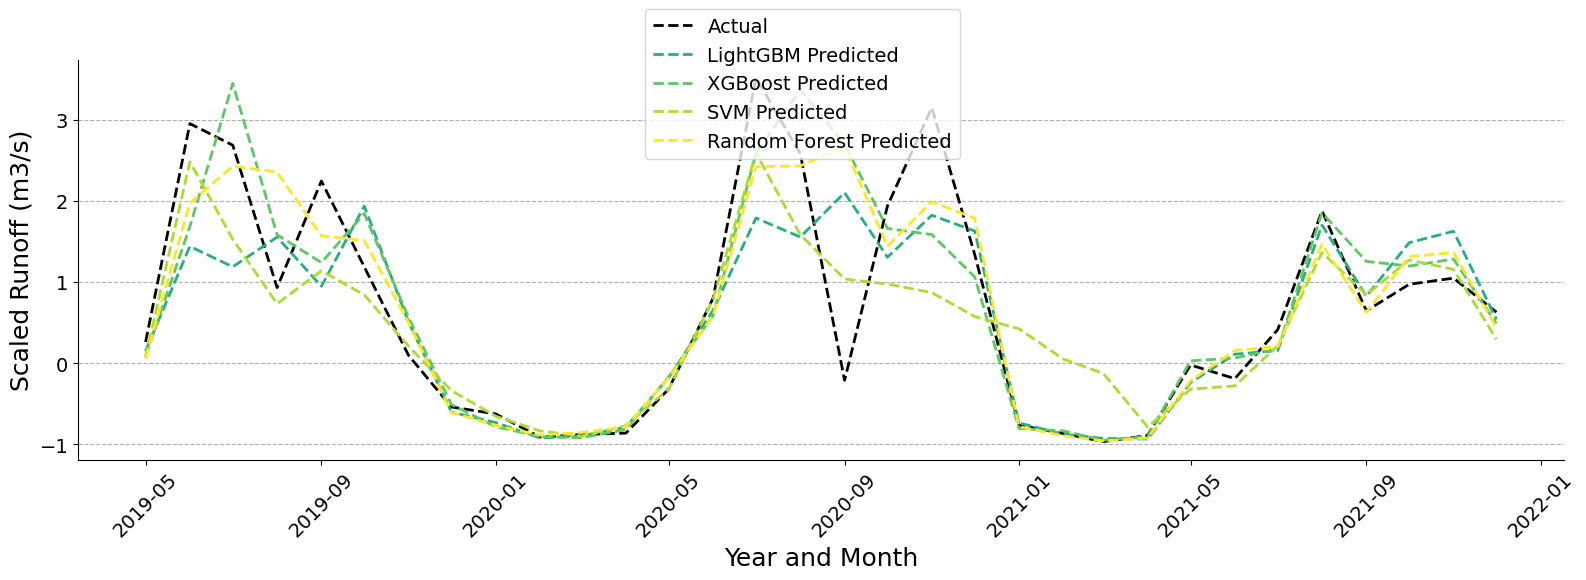

In [108]:

# Model names
models = [
    ('LightGBM', lightgbm_forecast),
    ('XGBoost', xgboost_forecast),
    ('SVM', svm_forecast),
    ('Random Forest', random_forest_forecast)
]

# Clear existing lists in case they contain previous values
model_names.clear()
mae_values.clear()
rmse_values.clear()
r2_values.clear()
nse_values.clear()
willmott_values.clear()

# Iterate over each model, perform walk-forward validation, and append metrics to lists
for model_name, model_func in models:
    mae, rmse, r2, nse, willmott, test_index, y, yhat = walk_forward_validation(data_df, model_func)
    
    model_names.append(model_name)
    mae_values.append(mae)
    rmse_values.append(rmse)
    r2_values.append(r2)
    nse_values.append(nse)
    willmott_values.append(willmott)

# Create a DataFrame
metrics = {
    'Model': model_names,
    'MAE': mae_values,
    'RMSE': rmse_values,
    'R-squared': r2_values,
    'Nash-Sutcliffe Efficiency': nse_values,
    'Willmott\'s Index of Agreement': willmott_values
}

metrics_df = pd.DataFrame(metrics)

# Plot the actual vs predicted values for each model
plt.figure(figsize=(16, 6))
plt.plot(test_index, y, label='Actual', linestyle='--', color='black', linewidth=2)



for model_name, model_func in models:
    _, _, _, _, _, test_index, _, yhat = walk_forward_validation(data_df, model_func)
    plt.plot(test_index, yhat, label=f'{model_name} Predicted', linestyle='--', color=colors_dict[model_name], linewidth=2)

plt.xlabel('Year and Month', fontsize=18)
plt.ylabel('Scaled Runoff (m3/s)', fontsize=18)

plt.legend(fontsize=14, loc='upper right', bbox_to_anchor=(0.6, 1.15), ncol=1)

plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)

plt.grid(axis='y', linestyle='--')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

### EVALUATE THE MODEL

In [109]:
# Create a DataFrame
metrics = {
    'Model': model_names,
    'MAE': mae_values,
    'RMSE': rmse_values,
    'R-squared': r2_values,
    'Nash-Sutcliffe Efficiency': nse_values,
    'Willmott\'s Index of Agreement': willmott_values
}

metrics = pd.DataFrame(metrics)

In [110]:
metrics

Model       MAE      RMSE  R-squared  Nash-Sutcliffe Efficiency  \
0       LightGBM  0.516156  0.789551   0.651963                   0.651963   
1        XGBoost  0.445748  0.741400   0.693119                   0.693119   
2            SVM  0.509029  0.725021   0.706528                   0.706528   
3  Random Forest  0.400728  0.703393   0.723776                   0.723776   

   Willmott's Index of Agreement  
0                       0.882968  
1                       0.916503  
2                       0.889898  
3                       0.922186

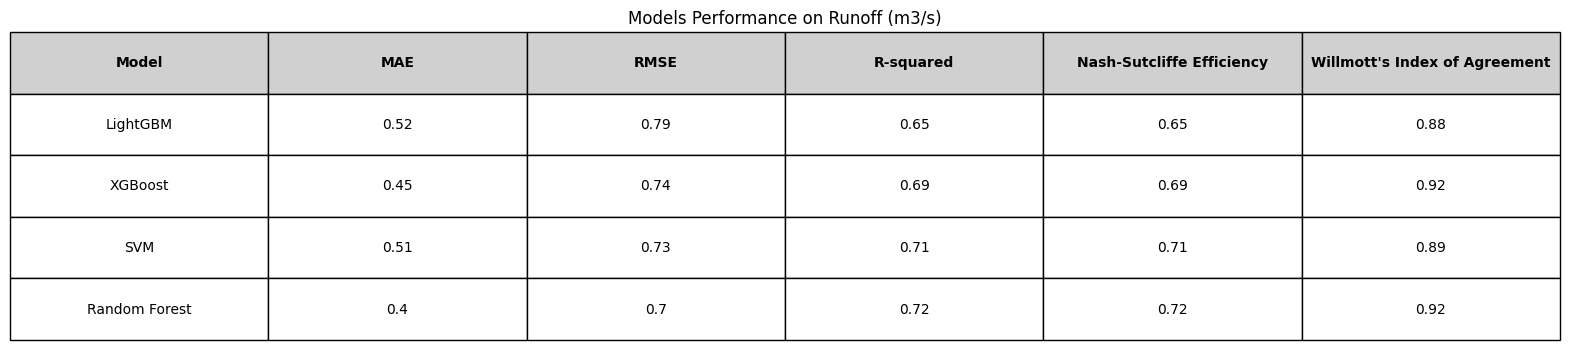

In [111]:
metrics = metrics.round(2)

fig, ax = plt.subplots(figsize=(20, 4))
ax.axis('off')

table = ax.table(cellText=metrics.values,
                 colLabels=metrics.columns,
                 cellLoc='center',
                 loc='center',
                 bbox=[0, 0, 1, 1])

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

header_color = '#D0D0D0'
data_color = '#FFFFFF'

for i, key in enumerate(table._cells):
    cell = table._cells[key]
    cell.set_edgecolor('black')
    if key[0] == 0 or key[1] == -1:
        cell.set_text_props(weight='bold')
        cell.set_facecolor(header_color)
    else:
        cell.set_facecolor(data_color)

plt.title('Models Performance on Runoff (m3/s)')
plt.show()


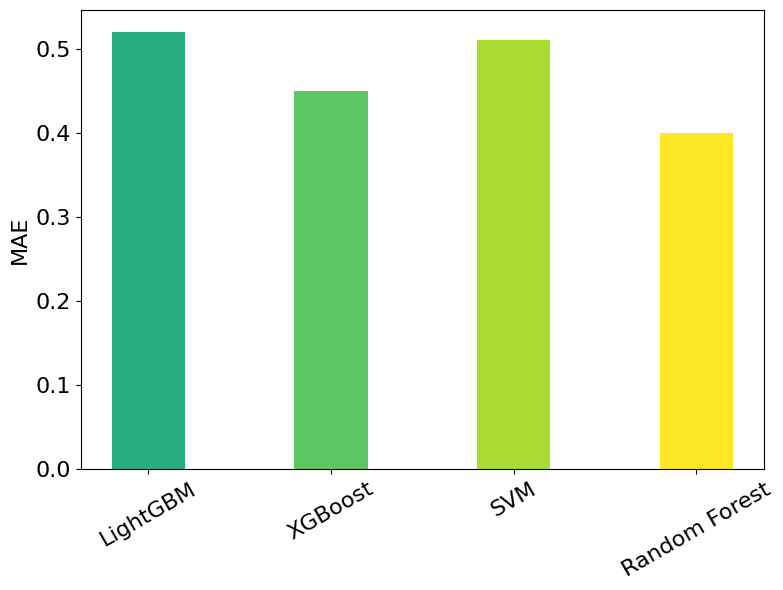

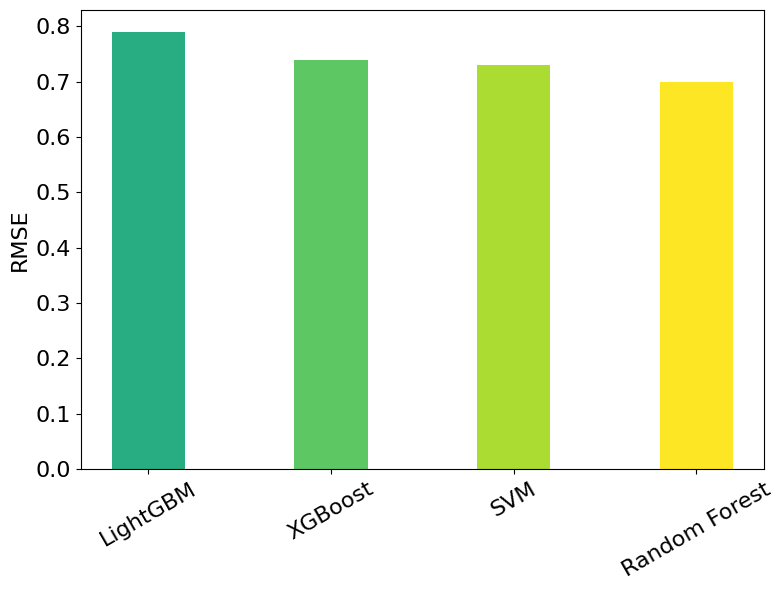

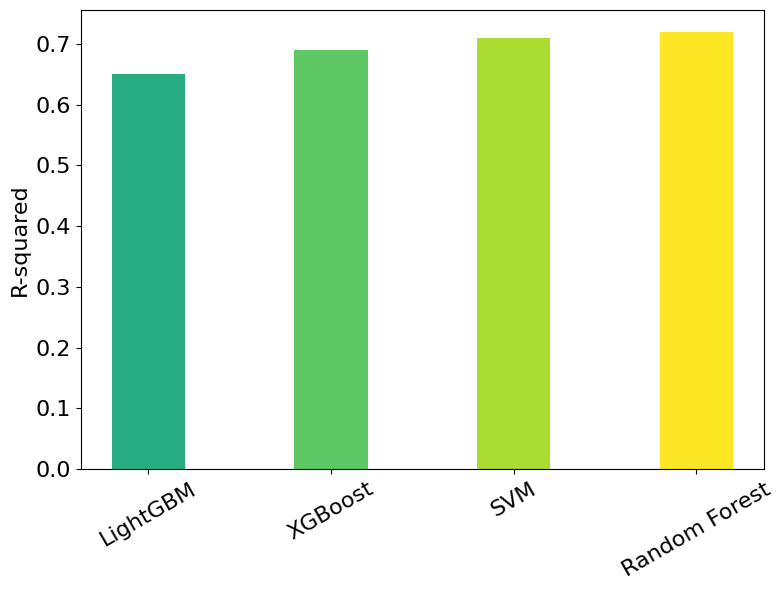

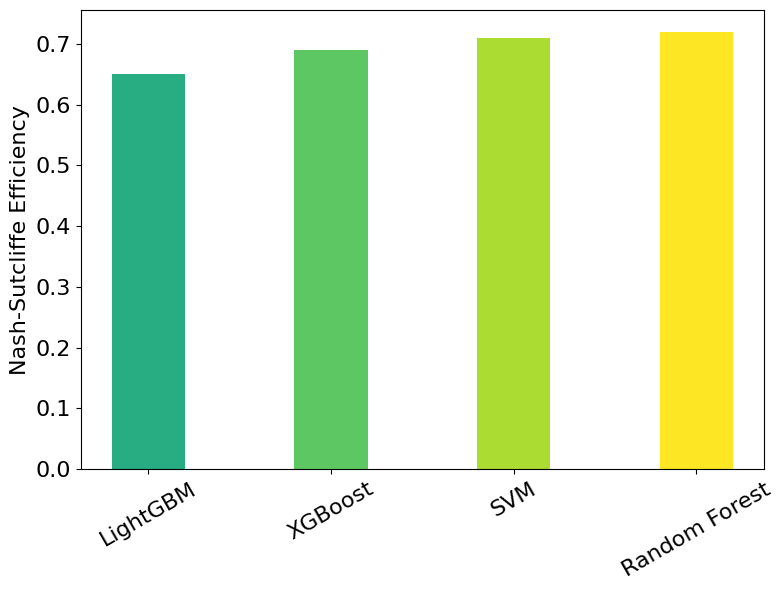

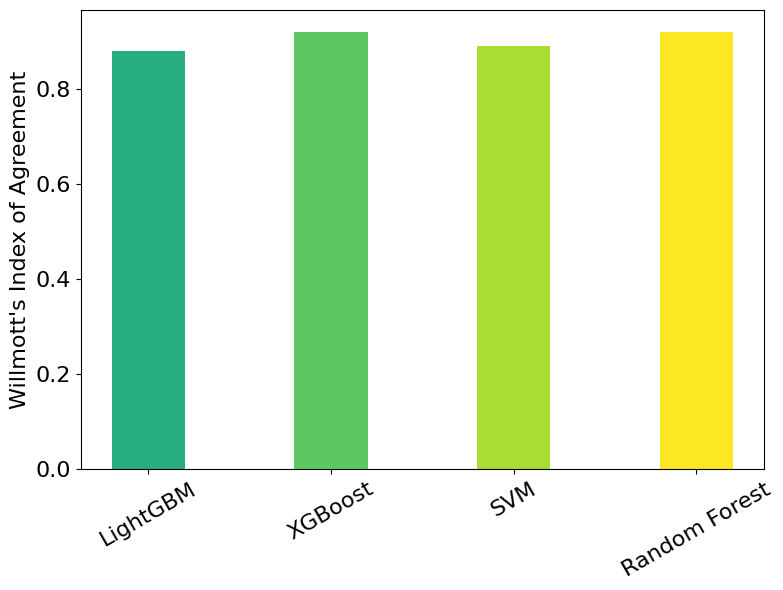

In [112]:

colors = ['#27ad81', '#5dc863', '#aadc32', '#fde725']
bar_width = 0.4

# Metrics and Titles
metrics_title = {
    'MAE': 'Mean Absolute Error (MAE)',
    'RMSE': 'Root Mean Squared Error (RMSE)',
    'R-squared': 'R-squared',
    'Nash-Sutcliffe Efficiency': 'Nash-Sutcliffe Efficiency',
    'Willmott\'s Index of Agreement': 'Willmott\'s Index of Agreement'
}

# Plot each metric separately
for metric, title in metrics_title.items():
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.bar(metrics['Model'], metrics[metric], color=colors, width=bar_width)
    # ax.set_title(title, fontsize=16)
    ax.set_ylabel(metric, fontsize=16)
    ax.tick_params(axis='x', rotation=30, labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    plt.tight_layout()
    plt.show()

### The End